
# Inital EDA (Quality Prediction in a Mining Process)
### Minute‑by‑Minute Soft Sensor for % SiO₂ in a Mineral Processing Circuit

This notebook covers the initial EDA for the Quality Prediction in a Mining Process dataset that can be found at:
    https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process
It produces a clean **1‑minute dataset** and a complete set of **high‑DPI slide assets** in `artifacts/`, with a concise **technical approach** and **ROI** visuals.

**Slides mapping:** Data Context → Initial EDA → Technical Approach → ROI.


In [ ]:

# Added simple configuration ("UI") so you guys can tweak plots
# Global configuration knobs for plots and analysis
TOPN_FEATURES = 15          # how many top features to show in correlation/lead-lag
LEAD_LAG_MAX  = 60          # lead/lag scan window (minutes)
FIRST_N_MIN   = 2000        # how many minutes to preview in the head plot
SPEC_UPPER    = None        # e.g., 2.5  (kept None by default)
SPEC_LOWER    = None        # e.g., 1.0

# plot/style defaults (high DPI for slides)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import zipfile

ART = Path("artifacts"); ART.mkdir(parents=True, exist_ok=True)
DATA = Path("data");      DATA.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", None)
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["figure.figsize"] = (8, 4)
mpl.rcParams["axes.grid"] = False
mpl.rcParams["font.size"] = 11
mpl.rcParams["axes.titlesize"] = 12
mpl.rcParams["axes.labelsize"] = 11
mpl.rcParams["legend.fontsize"] = 10
mpl.rcParams["lines.linewidth"] = 1.3



## 1) Robust Data Loading (ZIP/CSV; decimal‑comma) - Data Context


In [ ]:

# Edited loader to support both ZIP/CSV, decimal-comma, and to coerce numerics safely
from typing import Optional, Tuple

SEARCH_DIRS = [Path("datasets"), Path("."), Path("/mnt/data/datasets"), Path("/mnt/data")]
CSV_NAMES   = ["quality_prediction_in_a_mining_process.csv","quality_prediction_in_a_mining_process.csv.csv"]
ZIP_NAME    = "quality_prediction_in_a_mining_process.zip"

def _find_dataset() -> Tuple[Optional[Path], Optional[Path]]:
    z = next((d/ZIP_NAME for d in SEARCH_DIRS if (d/ZIP_NAME).exists()), None)
    if z: return z, None
    c = None
    for d in SEARCH_DIRS:
        for n in CSV_NAMES:
            p = d/n
            if p.exists(): c = p; break
        if c: break
    return None, c

def _read_csv(obj):
    try:    return pd.read_csv(obj, decimal=",", thousands=".")
    except: return pd.read_csv(obj)

def load_raw() -> pd.DataFrame:
    z, c = _find_dataset()
    if not z and not c:
        raise FileNotFoundError("Place Kaggle ZIP/CSV under ./datasets or /mnt/data")
    if z:
        with zipfile.ZipFile(z, 'r') as Z:
            inner = next((n for n in Z.namelist() if n.lower().endswith('.csv')), None)
            if not inner: raise FileNotFoundError("No CSV inside ZIP")
            with Z.open(inner) as f:
                df = _read_csv(f)
    else:
        df = _read_csv(c)
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
    else:
        for col in df.columns:
            s = pd.to_datetime(df[col], errors="coerce")
            if s.notna().mean() > 0.7: df["date"]=s; break
    for col in df.columns:
        if col != "date": df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df[df["date"].notna()].sort_values("date").reset_index(drop=True)
    return df

raw = load_raw()
print("Raw shape:", raw.shape)
raw.head()


Raw shape: (737453, 24)


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74000,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3185.55,586.182,404.648,10.1139,1.73614,250.488,250.488,249.214,295.096,306.4,250.137,248.950,450.139,510.332,461.638,422.888,451.528,510.098,513.904,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3182.03,595.947,407.168,10.1135,1.73545,250.620,252.334,249.390,295.096,306.4,256.465,251.499,440.530,518.600,465.414,405.704,433.686,513.794,512.252,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3180.86,600.464,402.598,10.1130,1.73476,250.576,250.620,249.258,295.096,306.4,250.137,250.269,443.833,510.446,456.246,415.706,428.618,481.874,468.224,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,1272.66,594.971,393.516,10.1125,1.73407,250.488,249.302,249.302,295.096,306.4,247.983,248.511,453.242,502.968,451.604,441.878,427.296,433.372,412.824,66.91,1.31



## 2) Data Context Summary (dictionary, size, missingness)


In [ ]:

# Added a structured data dictionary table for slides
def data_dictionary(df: pd.DataFrame, datetime_col: str = "date") -> pd.DataFrame:
    dtypes = df.dtypes.astype(str)
    rows = []
    for c in df.columns:
        if c == datetime_col:
            rows.append({"column": c, "dtype": "datetime64[ns]",
                         "non_null": df[c].notna().sum(), "missing_%": 100*(1 - df[c].notna().mean()),
                         "min": None, "median": None, "max": None})
            continue
        s = df[c]; nonnull = s.notna().sum(); missp = float(100*(1 - s.notna().mean()))
        if pd.api.types.is_numeric_dtype(s):
            rows.append({"column": c, "dtype": dtypes[c], "non_null": int(nonnull),
                         "missing_%": missp,
                         "min": float(s.min(skipna=True)) if nonnull else None,
                         "median": float(s.median(skipna=True)) if nonnull else None,
                         "max": float(s.max(skipna=True)) if nonnull else None})
        else:
            rows.append({"column": c, "dtype": dtypes[c], "non_null": int(nonnull),
                         "missing_%": missp, "min": None, "median": None, "max": None})
    return pd.DataFrame(rows).sort_values("missing_%", ascending=False).reset_index(drop=True)

dict_df = data_dictionary(raw)
dict_df.to_csv(ART/"data_dictionary.csv", index=False)
dict_df.head(12)


,column,dtype,non_null,missing_%,min,median,max
0,date,datetime64[ns],737453,0.0,NaN,NaN,NaN
1,% Iron Feed,float64,737453,0.0,42.740,56.080000,65.780
2,% Iron Concentrate,float64,737453,0.0,62.050,65.210000,68.010
3,Flotation Column 07 Level,float64,737453,0.0,175.349,411.065000,659.902
4,Flotation Column 06 Level,float64,737453,0.0,155.841,424.664575,698.861
5,Flotation Column 05 Level,float64,737453,0.0,166.991,408.773000,675.644
6,Flotation Column 04 Level,float64,737453,0.0,162.201,411.974000,680.359
7,Flotation Column 03 Level,float64,737453,0.0,126.255,494.318000,886.822
8,Flotation Column 02 Level,float64,737453,0.0,210.752,495.956000,828.919
9,Flotation Column 01 Level,float64,737453,0.0,149.218,491.878000,862.274



## 3) Sampling & Timeline Reconstruction (20‑sec → 1‑min)


In [ ]:

# Removed 180-row/hour padding; reconstruct true 20s ordering and resample to 1-minute means
per_hour_counts = raw['date'].value_counts().sort_index()
per_hour_counts.describe()


count    4097.000000
mean      179.998291
std         0.095028
min       174.000000
25%       180.000000
50%       180.000000
75%       180.000000
max       180.000000
Name: count, dtype: float64

20s shape: (737453, 24) | 1-min shape: (264900, 23)


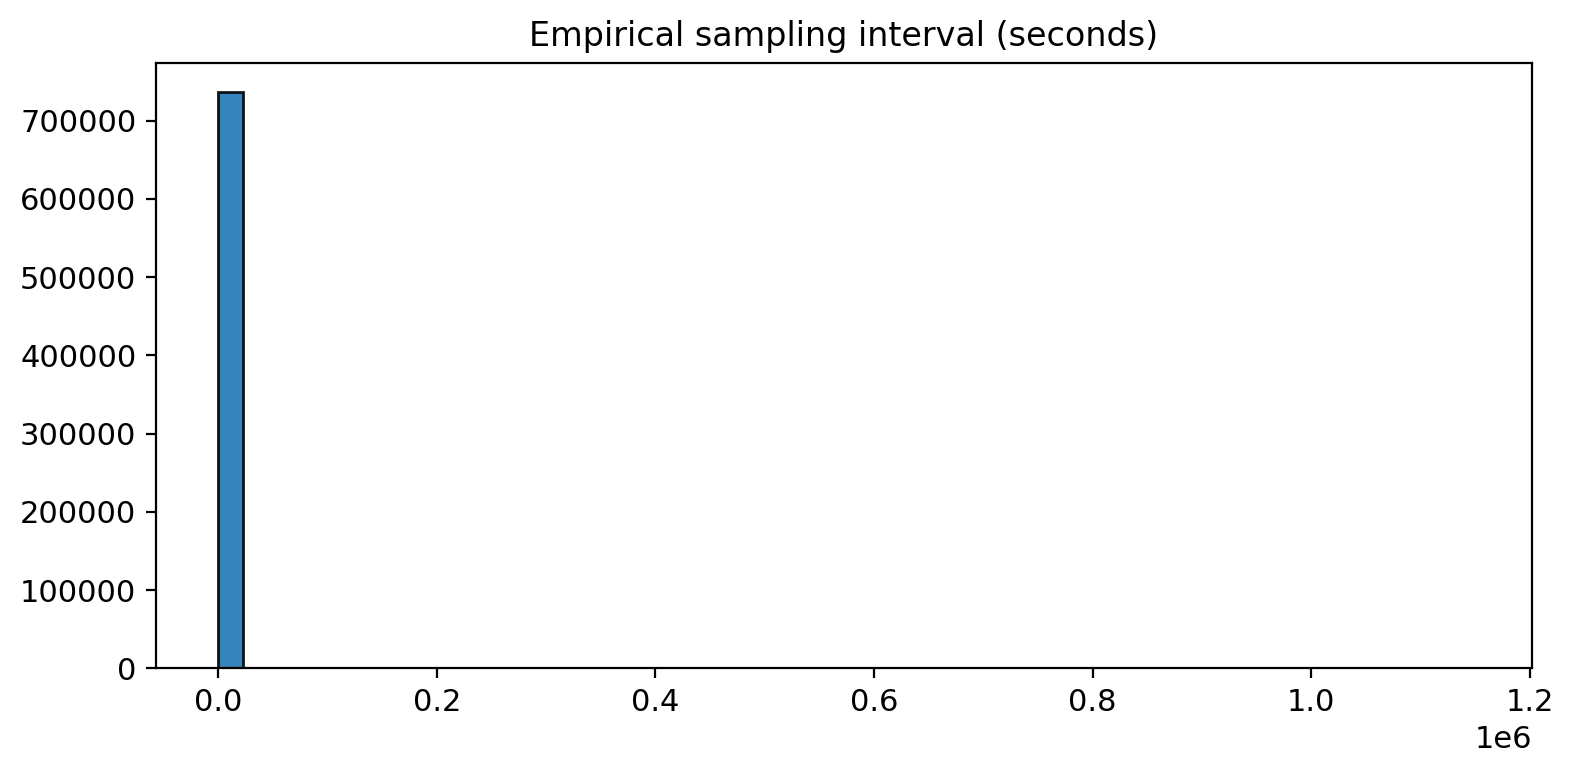

In [ ]:

def reconstruct_20s_index(df: pd.DataFrame) -> pd.DataFrame:
    groups = []
    for hour_ts, g in df.groupby("date", sort=True):
        n = len(g)
        offsets = pd.to_timedelta(np.arange(n) * 20, unit="s")
        gg = g.copy()
        gg["timestamp"] = hour_ts + offsets
        groups.append(gg)
    out = pd.concat(groups, axis=0).sort_values("timestamp").set_index("timestamp")
    out.index.name = "timestamp"
    return out

ts20 = reconstruct_20s_index(raw)
num20 = ts20.select_dtypes(include=["number"])
min1  = num20.resample("1T").mean()
print("20s shape:", ts20.shape, "| 1-min shape:", min1.shape)

# Sampling-interval histogram (empirical cadence evidence)
deltas = np.diff(ts20.index.view('i8')) / 1e9
deltas = deltas[deltas>0]
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(deltas, bins=50, alpha=0.9, edgecolor="black")
ax.set_title("Empirical sampling interval (seconds)")
fig.tight_layout(); fig.savefig(ART/"interval_hist.png", bbox_inches="tight")
plt.show()



### 3a) Quality Gates for the minute dataset


In [ ]:

# Added fast assertions to prevent silent regressions
assert min1.index.is_monotonic_increasing, "Index must be monotonic increasing"
assert min1.index.is_unique, "Index must be unique at 1‑minute res"
assert (min1.index.inferred_freq is None) or (str(min1.index.inferred_freq).endswith('T')), "Index should be minute‑like"

missing_rate = 1 - min1.notna().mean()
bad_cols = missing_rate[missing_rate > 0.60].index.tolist()
print("Columns >60% missing (non‑blocking info):", bad_cols[:8], "...")

if "% Silica Concentrate" in min1.columns:
    s = min1["% Silica Concentrate"].dropna()
    if len(s) > 100:
        lo, hi = s.quantile([0.001, 0.999]).tolist()
        assert lo >= 0, "Target has negative near‑support values (unexpected)"
        assert hi <= 10, "Target near‑support >10% (unexpected)"
print("Quality gates passed.")


Columns >60% missing (non‑blocking info): [] ...
Quality gates passed.



## 4) Target Selection & Summary


In [ ]:

# Same target preferences
tgt = None
for cand in ["% Silica Concentrate", "% Silica Feed"]:
    if cand in min1.columns: tgt = cand; break
if tgt is None:
    for c in min1.columns:
        cl = c.lower()
        if "sio2" in cl or "silica" in cl or cl.startswith("si"): tgt = c; break
print("Target:", tgt)
min1.describe().T.head(8)


Target: % Silica Concentrate


,count,mean,std,min,25%,50%,75%,max
% Iron Feed,245818.0,56.294739,5.157748,42.740000,52.670000,56.080000,59.720000,65.780000
% Silica Feed,245818.0,14.651714,6.807443,1.310000,8.940000,13.850000,19.600000,33.400000
Starch Flow,245818.0,2869.139402,1161.742606,0.195981,2080.296667,2974.890000,3695.293333,6294.580469
Amina Flow,245818.0,488.144547,90.139754,241.699421,432.241083,504.169667,553.247583,739.369400
Ore Pulp Flow,245818.0,397.578359,9.357791,376.272200,395.507710,399.410667,402.283223,418.618069
Ore Pulp pH,245818.0,9.767639,0.386589,8.753370,9.527562,9.798140,10.037467,10.808063
Ore Pulp Density,245818.0,1.680380,0.068839,1.519826,1.647373,1.697400,1.727907,1.853207
Flotation Column 01 Air Flow,245818.0,280.151815,29.602354,175.752108,250.249333,299.461667,300.105333,372.387588


### Plot helpers

In [ ]:

def plot_hist_with_kde(series: pd.Series, title: str, out_png: str, bins: int = 60):
    # Added KDE overlay and consistent styling for slides
    x = series.dropna()
    if x.empty:
        print("WARN: series empty; skipping", title); return
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(x.values, bins=bins, alpha=0.85, edgecolor="black")
    try:
        x.plot(kind="kde", ax=ax)
    except Exception:
        pass
    ax.set_title(title); ax.set_xlabel(series.name); ax.set_ylabel("count")
    fig.tight_layout(); fig.savefig(out_png, bbox_inches="tight")
    plt.show()

def scatter_with_binned_trend(x: pd.Series, y: pd.Series, title: str, out_png: str, n_bins: int = 50):
    # Adds binned trendline (robust mean per quantile bin) to clarify relationships
    m = x.notna() & y.notna()
    xx, yy = x[m].values, y[m].values
    if len(xx) < 100:
        print("WARN: too few points for", title); return
    fig, ax = plt.subplots(figsize=(7,4))
    ax.scatter(xx, yy, s=5, alpha=0.25)
    qs = np.linspace(0, 1, n_bins+1)
    edges = np.quantile(xx, qs); edges = np.unique(edges)
    centers, means = [], []
    for i in range(len(edges)-1):
        mask = (xx >= edges[i]) & (xx < edges[i+1])
        if mask.sum() >= 10:
            centers.append(np.mean([edges[i], edges[i+1]]))
            means.append(np.mean(yy[mask]))
    if centers:
        ax.plot(centers, means)
    ax.set_title(title); ax.set_xlabel(x.name); ax.set_ylabel(y.name)
    fig.tight_layout(); fig.savefig(out_png, bbox_inches="tight")
    plt.show()

def annotated_corr_heatmap(df: pd.DataFrame, title: str, out_png: str, fmt: str=".2f"):
    # Annotated numeric values for readability in slides
    M = df.values
    fig, ax = plt.subplots(figsize=(min(14, 1.0*df.shape[1]+6), min(12, 0.6*df.shape[0]+4)))
    im = ax.imshow(M, aspect="auto", interpolation="nearest")
    ax.set_xticks(range(df.shape[1])); ax.set_xticklabels(df.columns, rotation=45, ha="right")
    ax.set_yticks(range(df.shape[0])); ax.set_yticklabels(df.index)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            val = M[i, j]
            if np.isfinite(val):
                ax.text(j, i, format(val, fmt), ha="center", va="center", fontsize=8)
    fig.tight_layout(); fig.savefig(out_png, bbox_inches="tight")
    plt.show()



## 5) Missingness Suite (rates, heatmap, longest run) + Daily Coverage


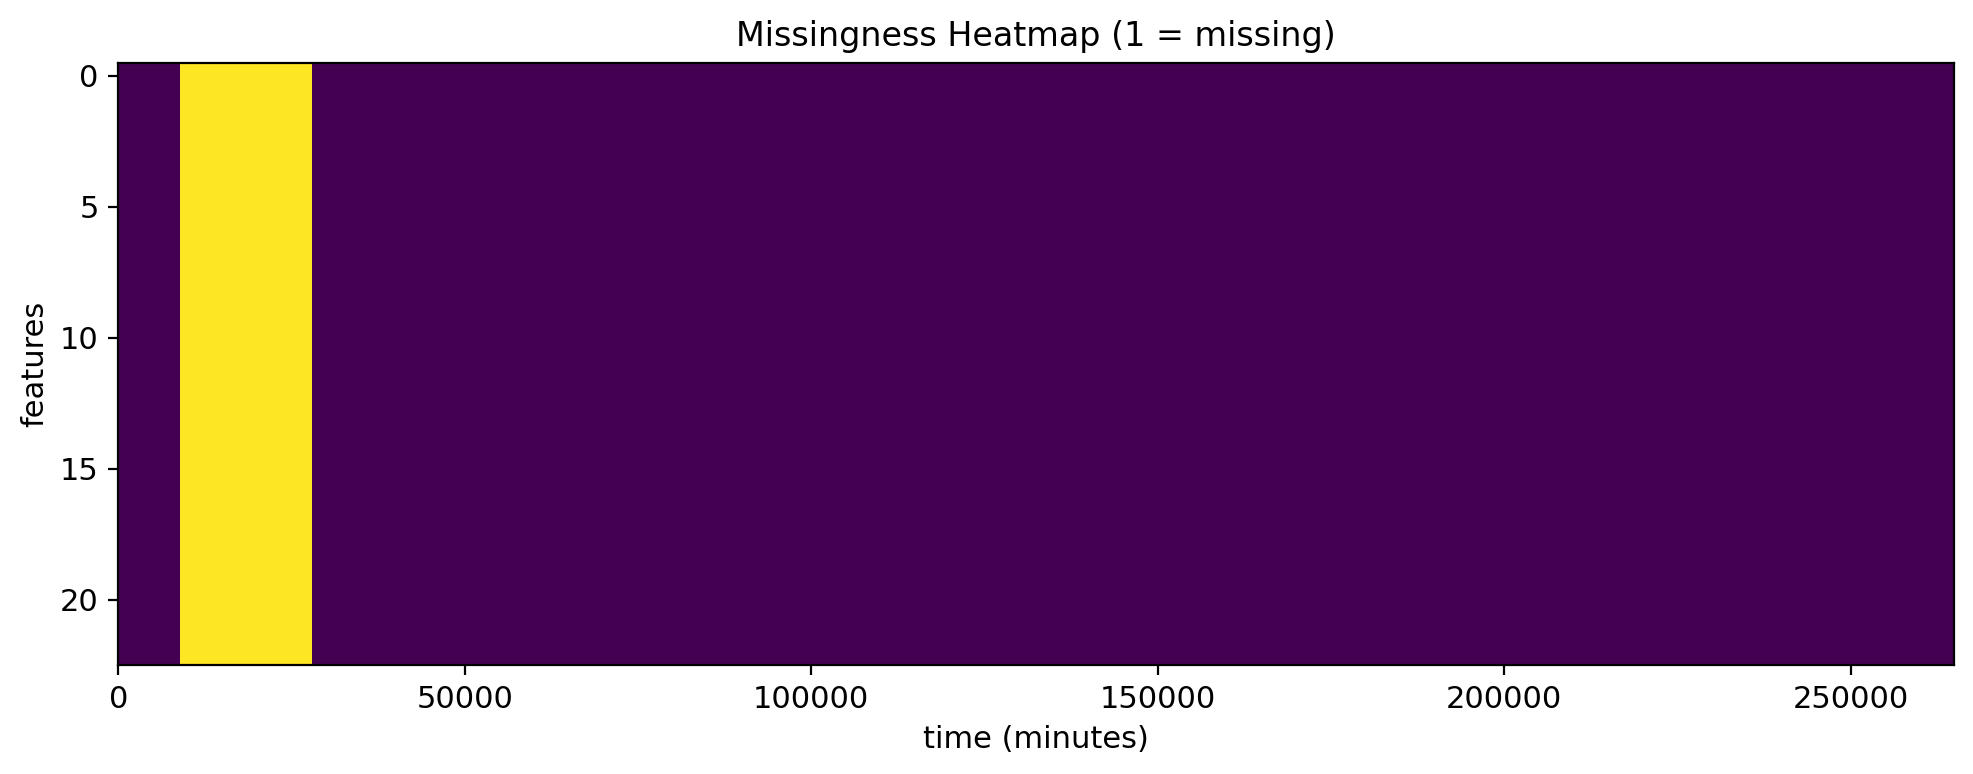

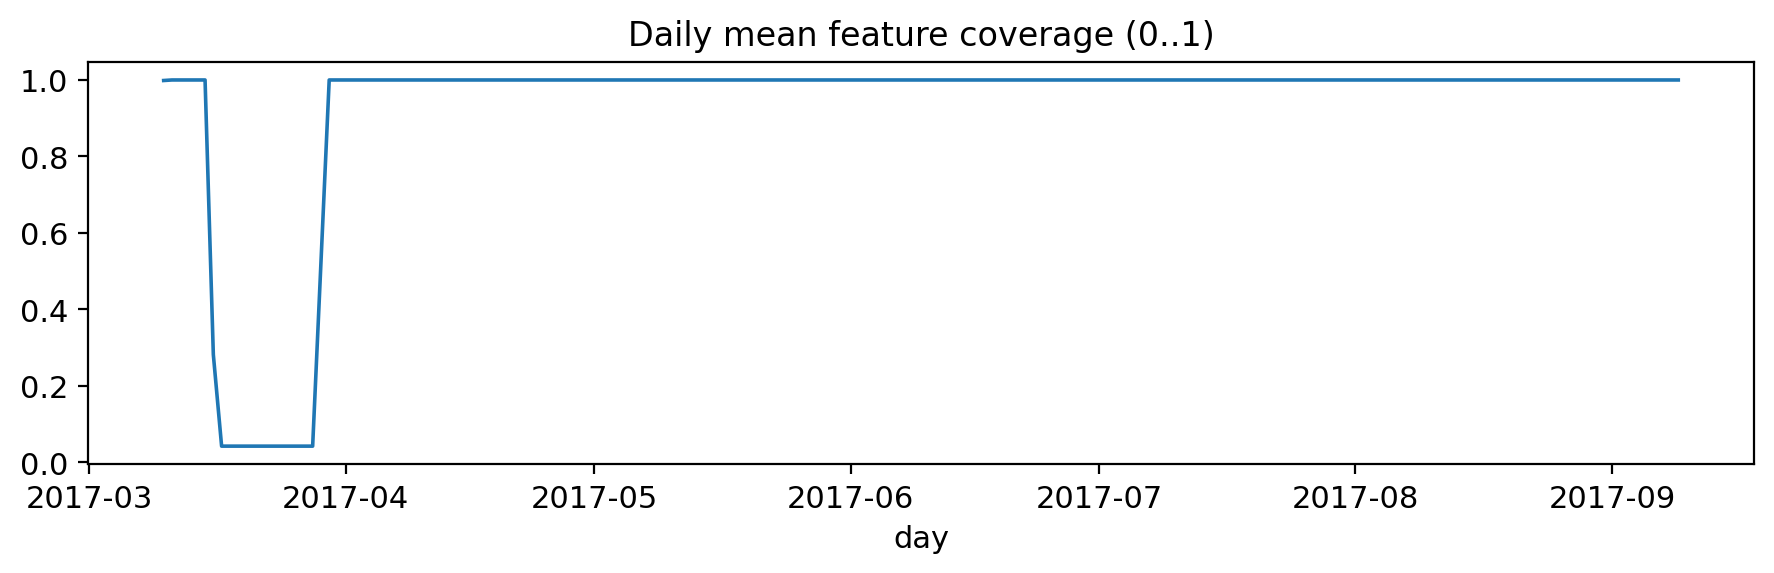

In [ ]:

# Added quantitative missingness metrics and longest-run diagnostics
miss_pct = (1 - min1.notna().mean()).sort_values(ascending=False)
miss_pct.to_csv(ART/"missingness_rate.csv")
miss_pct.head(10)

miss = min1.isna().astype(int).values
fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(miss.T, aspect="auto", interpolation="nearest")
ax.set_title("Missingness Heatmap (1 = missing)")
ax.set_xlabel("time (minutes)"); ax.set_ylabel("features")
fig.tight_layout(); fig.savefig(ART/"missingness_heatmap.png", bbox_inches="tight")
plt.show()

runs = {}
for c in min1.columns:
    mask = min1[c].isna().astype(int).values
    longest, cur = 0, 0
    for v in mask:
        cur = cur + 1 if v==1 else 0
        if cur > longest: longest = cur
    runs[c] = longest
run_df = pd.Series(runs).sort_values(ascending=False).to_frame("longest_missing_run_minutes")
run_df.to_csv(ART/"missing_run_lengths.csv")
run_df.head(10)

# Daily mean feature coverage (stakeholder-friendly)
daily = min1.assign(day=min1.index.date)
daily_cov = daily.groupby("day").apply(lambda x: x.notna().mean()).iloc[:, :].mean(axis=1)
daily_cov = daily_cov.to_frame("mean_feature_coverage")
daily_cov.to_csv("artifacts/daily_mean_feature_coverage.csv")
ax = daily_cov.plot(figsize=(9,3), legend=False)
ax.set_title("Daily mean feature coverage (0..1)")
ax.figure.tight_layout(); ax.figure.savefig("artifacts/daily_coverage.png", bbox_inches="tight")
plt.show()



## 6) Outlier Diagnostics (robust z via MAD)


In [ ]:

# Quantify robustness issues without silently filtering anything in feasibility
def robust_z_mad(s: pd.Series):
    m = np.nanmedian(s.values)
    mad = np.nanmedian(np.abs(s.values - m))
    if mad == 0 or np.isnan(mad):
        return np.zeros_like(s.values, dtype=float)
    return 0.6745 * (s.values - m) / mad

outlier_rates = {}
for c in min1.columns:
    z = robust_z_mad(min1[c])
    rate = np.nanmean(np.abs(z) > 6)  # conservative threshold
    outlier_rates[c] = rate
outlier_df = pd.Series(outlier_rates).sort_values(ascending=False).to_frame("outlier_rate")
outlier_df.to_csv(ART/"outlier_rates.csv")
outlier_df.head(10)


,outlier_rate
Flotation Column 02 Air Flow,0.337671
Flotation Column 06 Air Flow,0.329773
Flotation Column 01 Air Flow,0.322650
Flotation Column 03 Air Flow,0.308762
Flotation Column 07 Air Flow,0.302008
Flotation Column 05 Air Flow,0.002337
Flotation Column 04 Air Flow,0.000310
Flotation Column 02 Level,0.000000
% Iron Concentrate,0.000000
Flotation Column 07 Level,0.000000



## 7) Target Distribution & Time Trends (leak-safe)


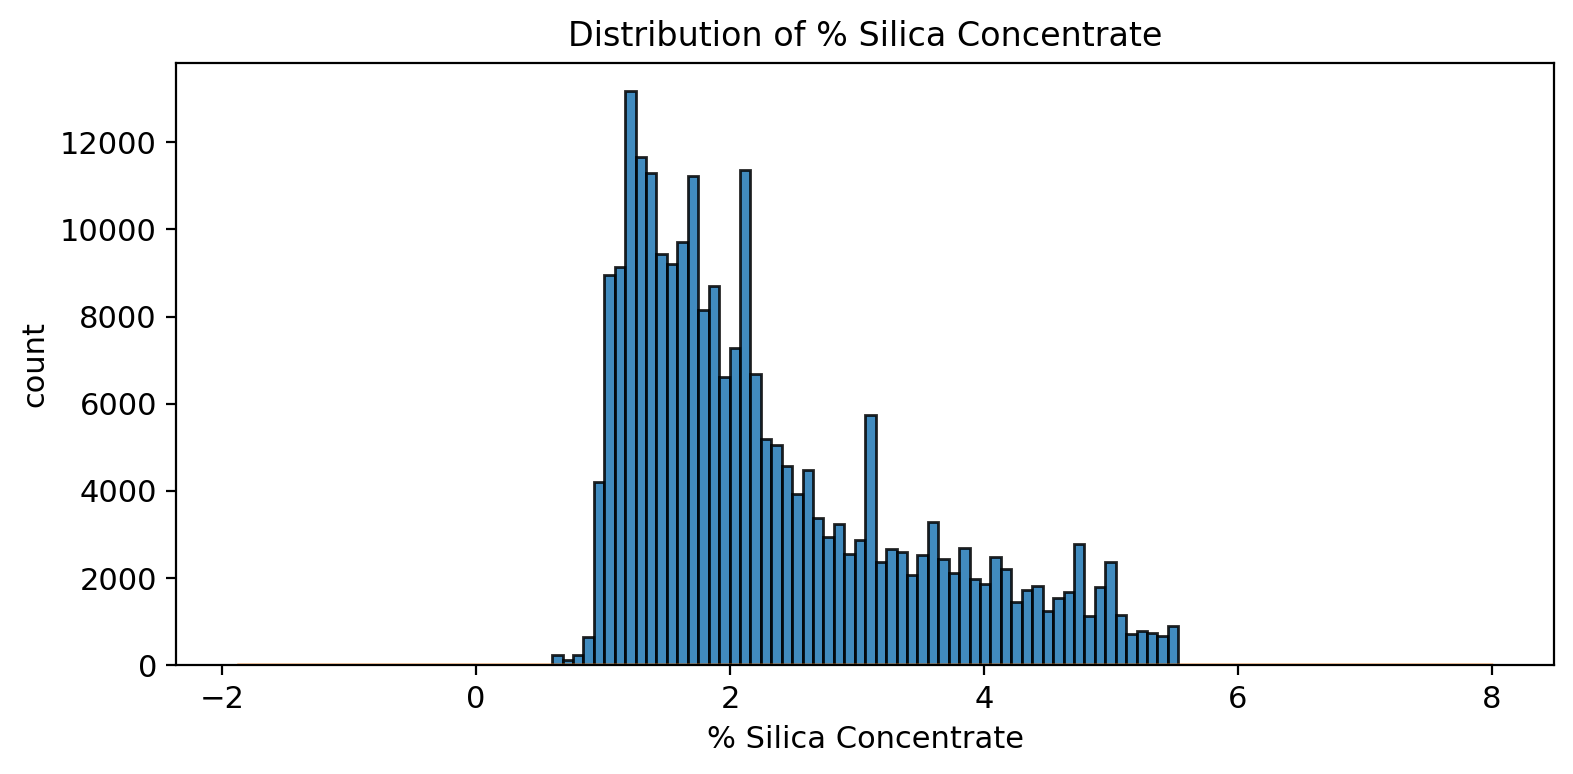

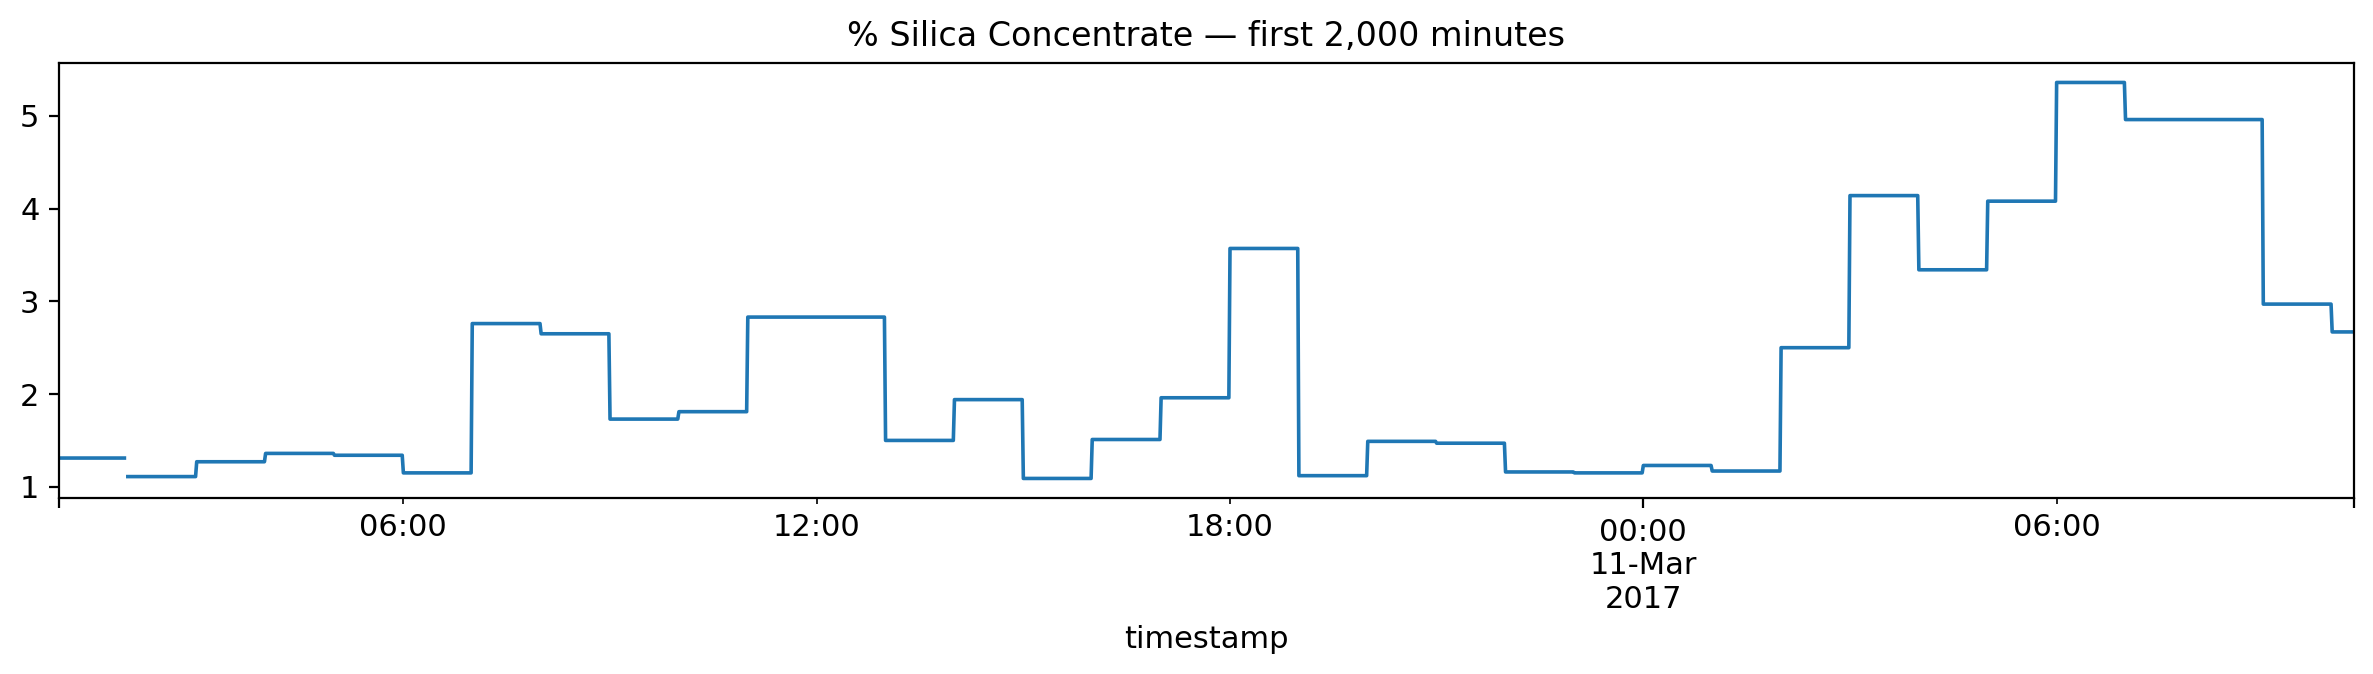

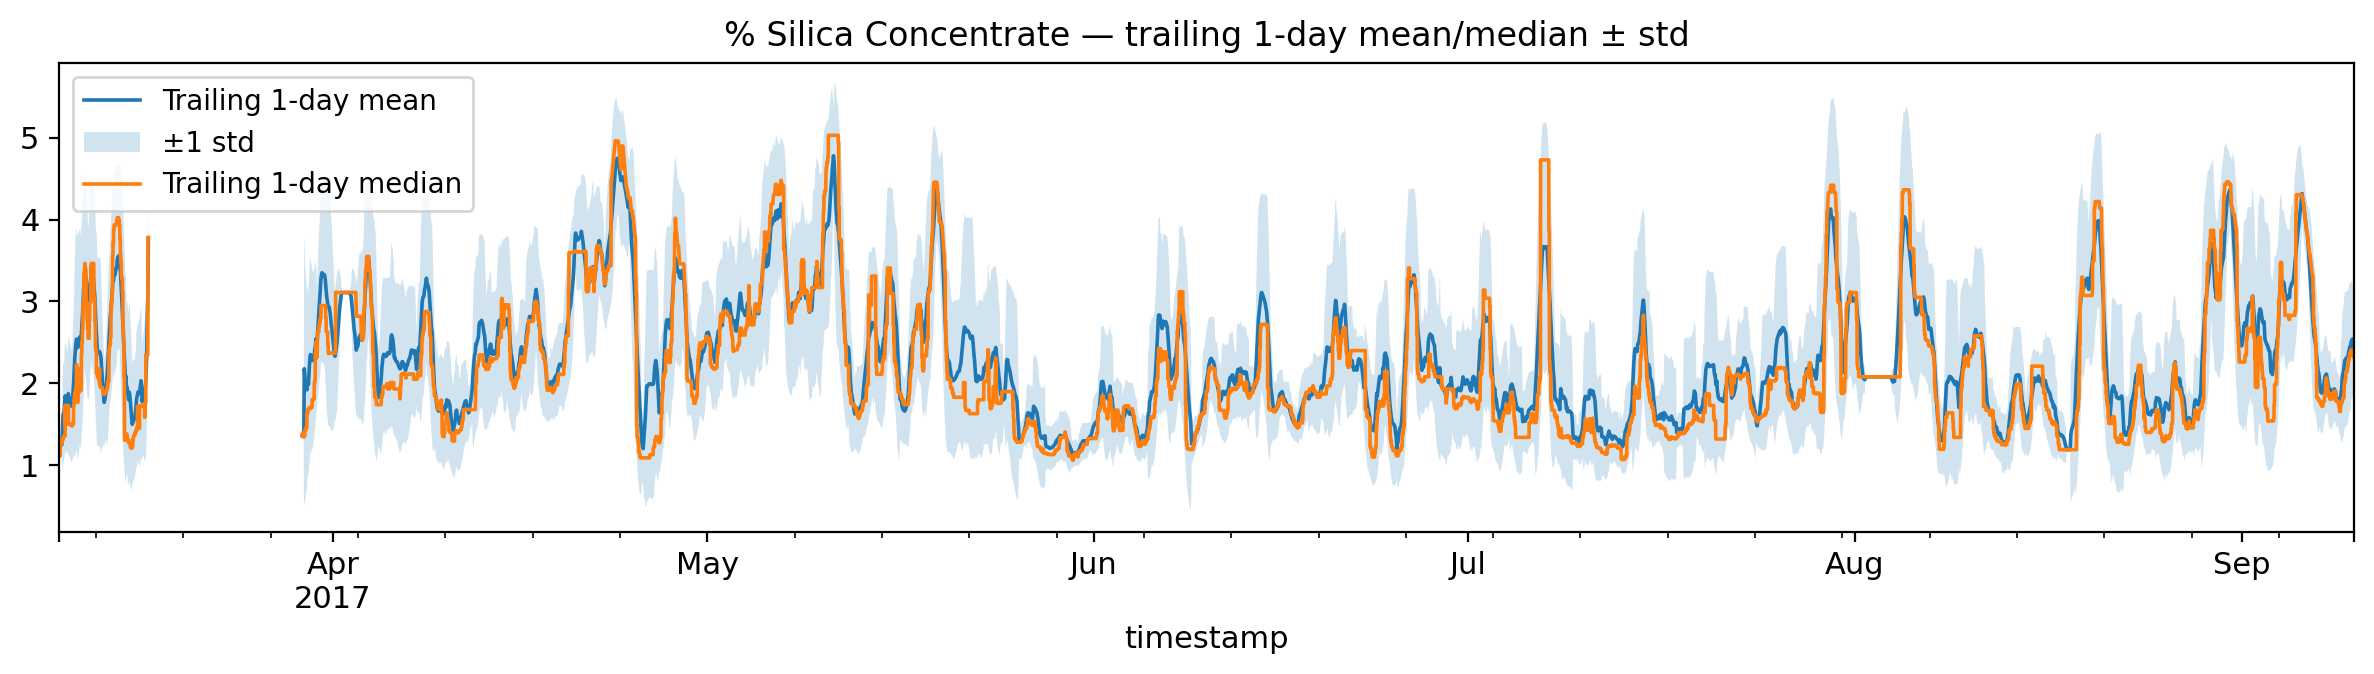

In [ ]:

plot_hist_with_kde(min1[tgt], title=f"Distribution of {tgt}", out_png="artifacts/target_distribution.png", bins=60)

fig, ax = plt.subplots(figsize=(12,3.5))
min1[tgt].iloc[:FIRST_N_MIN].plot(ax=ax)
ax.set_title(f"{tgt} — first {FIRST_N_MIN:,} minutes")
fig.tight_layout(); fig.savefig(ART/"target_timeseries_head.png", bbox_inches="tight")
plt.show()

s = min1[tgt].copy()
roll = s.rolling(window=1440, min_periods=60)  # trailing 1-day
mean = roll.mean(); std = roll.std(); med = roll.median()
fig, ax = plt.subplots(figsize=(12,3.5))
mean.plot(ax=ax, label="Trailing 1-day mean")
ax.fill_between(mean.index, (mean-std).values, (mean+std).values, alpha=0.2, label="±1 std")
med.plot(ax=ax, label="Trailing 1-day median")
ax.set_title(f"{tgt} — trailing 1-day mean/median ± std")
ax.legend()
fig.tight_layout(); fig.savefig(ART/"target_trailing_1d.png", bbox_inches="tight")
plt.show()

# spec overlay (off by default)
if SPEC_UPPER or SPEC_LOWER:
    fig, ax = plt.subplots(figsize=(12,3.5))
    min1[tgt].plot(ax=ax, alpha=0.8)
    if SPEC_UPPER: ax.axhline(SPEC_UPPER, linestyle="--")
    if SPEC_LOWER: ax.axhline(SPEC_LOWER, linestyle="--")
    ax.set_title(f"{tgt} with spec overlays")
    fig.tight_layout(); fig.savefig("artifacts/target_with_spec.png", bbox_inches="tight")
    plt.show()



## 8) Target Autocorrelation (ACF)


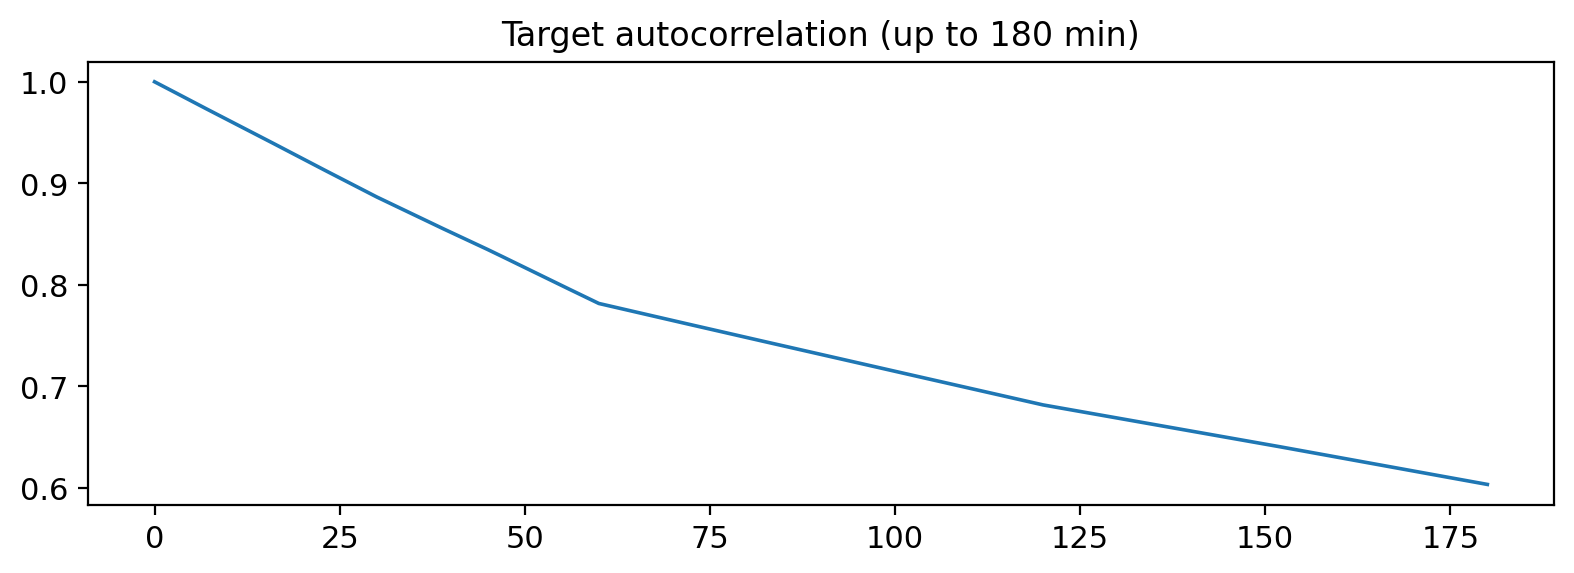

In [ ]:

# NaN-safe interpolation (plotting only) avoids empty charts
def autocorr_nan_safe(series: pd.Series, max_lag=180):
    y = pd.Series(series).copy()
    y = y.interpolate("time").ffill().bfill().values
    ac = [1.0]
    for L in range(1, max_lag+1):
        if L < len(y):
            v = np.corrcoef(y[:-L], y[L:])[0,1]
        else:
            v = np.nan
        ac.append(v)
    return np.array(ac)

ac = autocorr_nan_safe(min1[tgt], 180)
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(ac)
ax.set_title("Target autocorrelation (up to 180 min)")
fig.tight_layout(); fig.savefig(ART/"target_acf.png", bbox_inches="tight")
plt.show()



## 9) Correlations (Pearson) - annotated & clustered


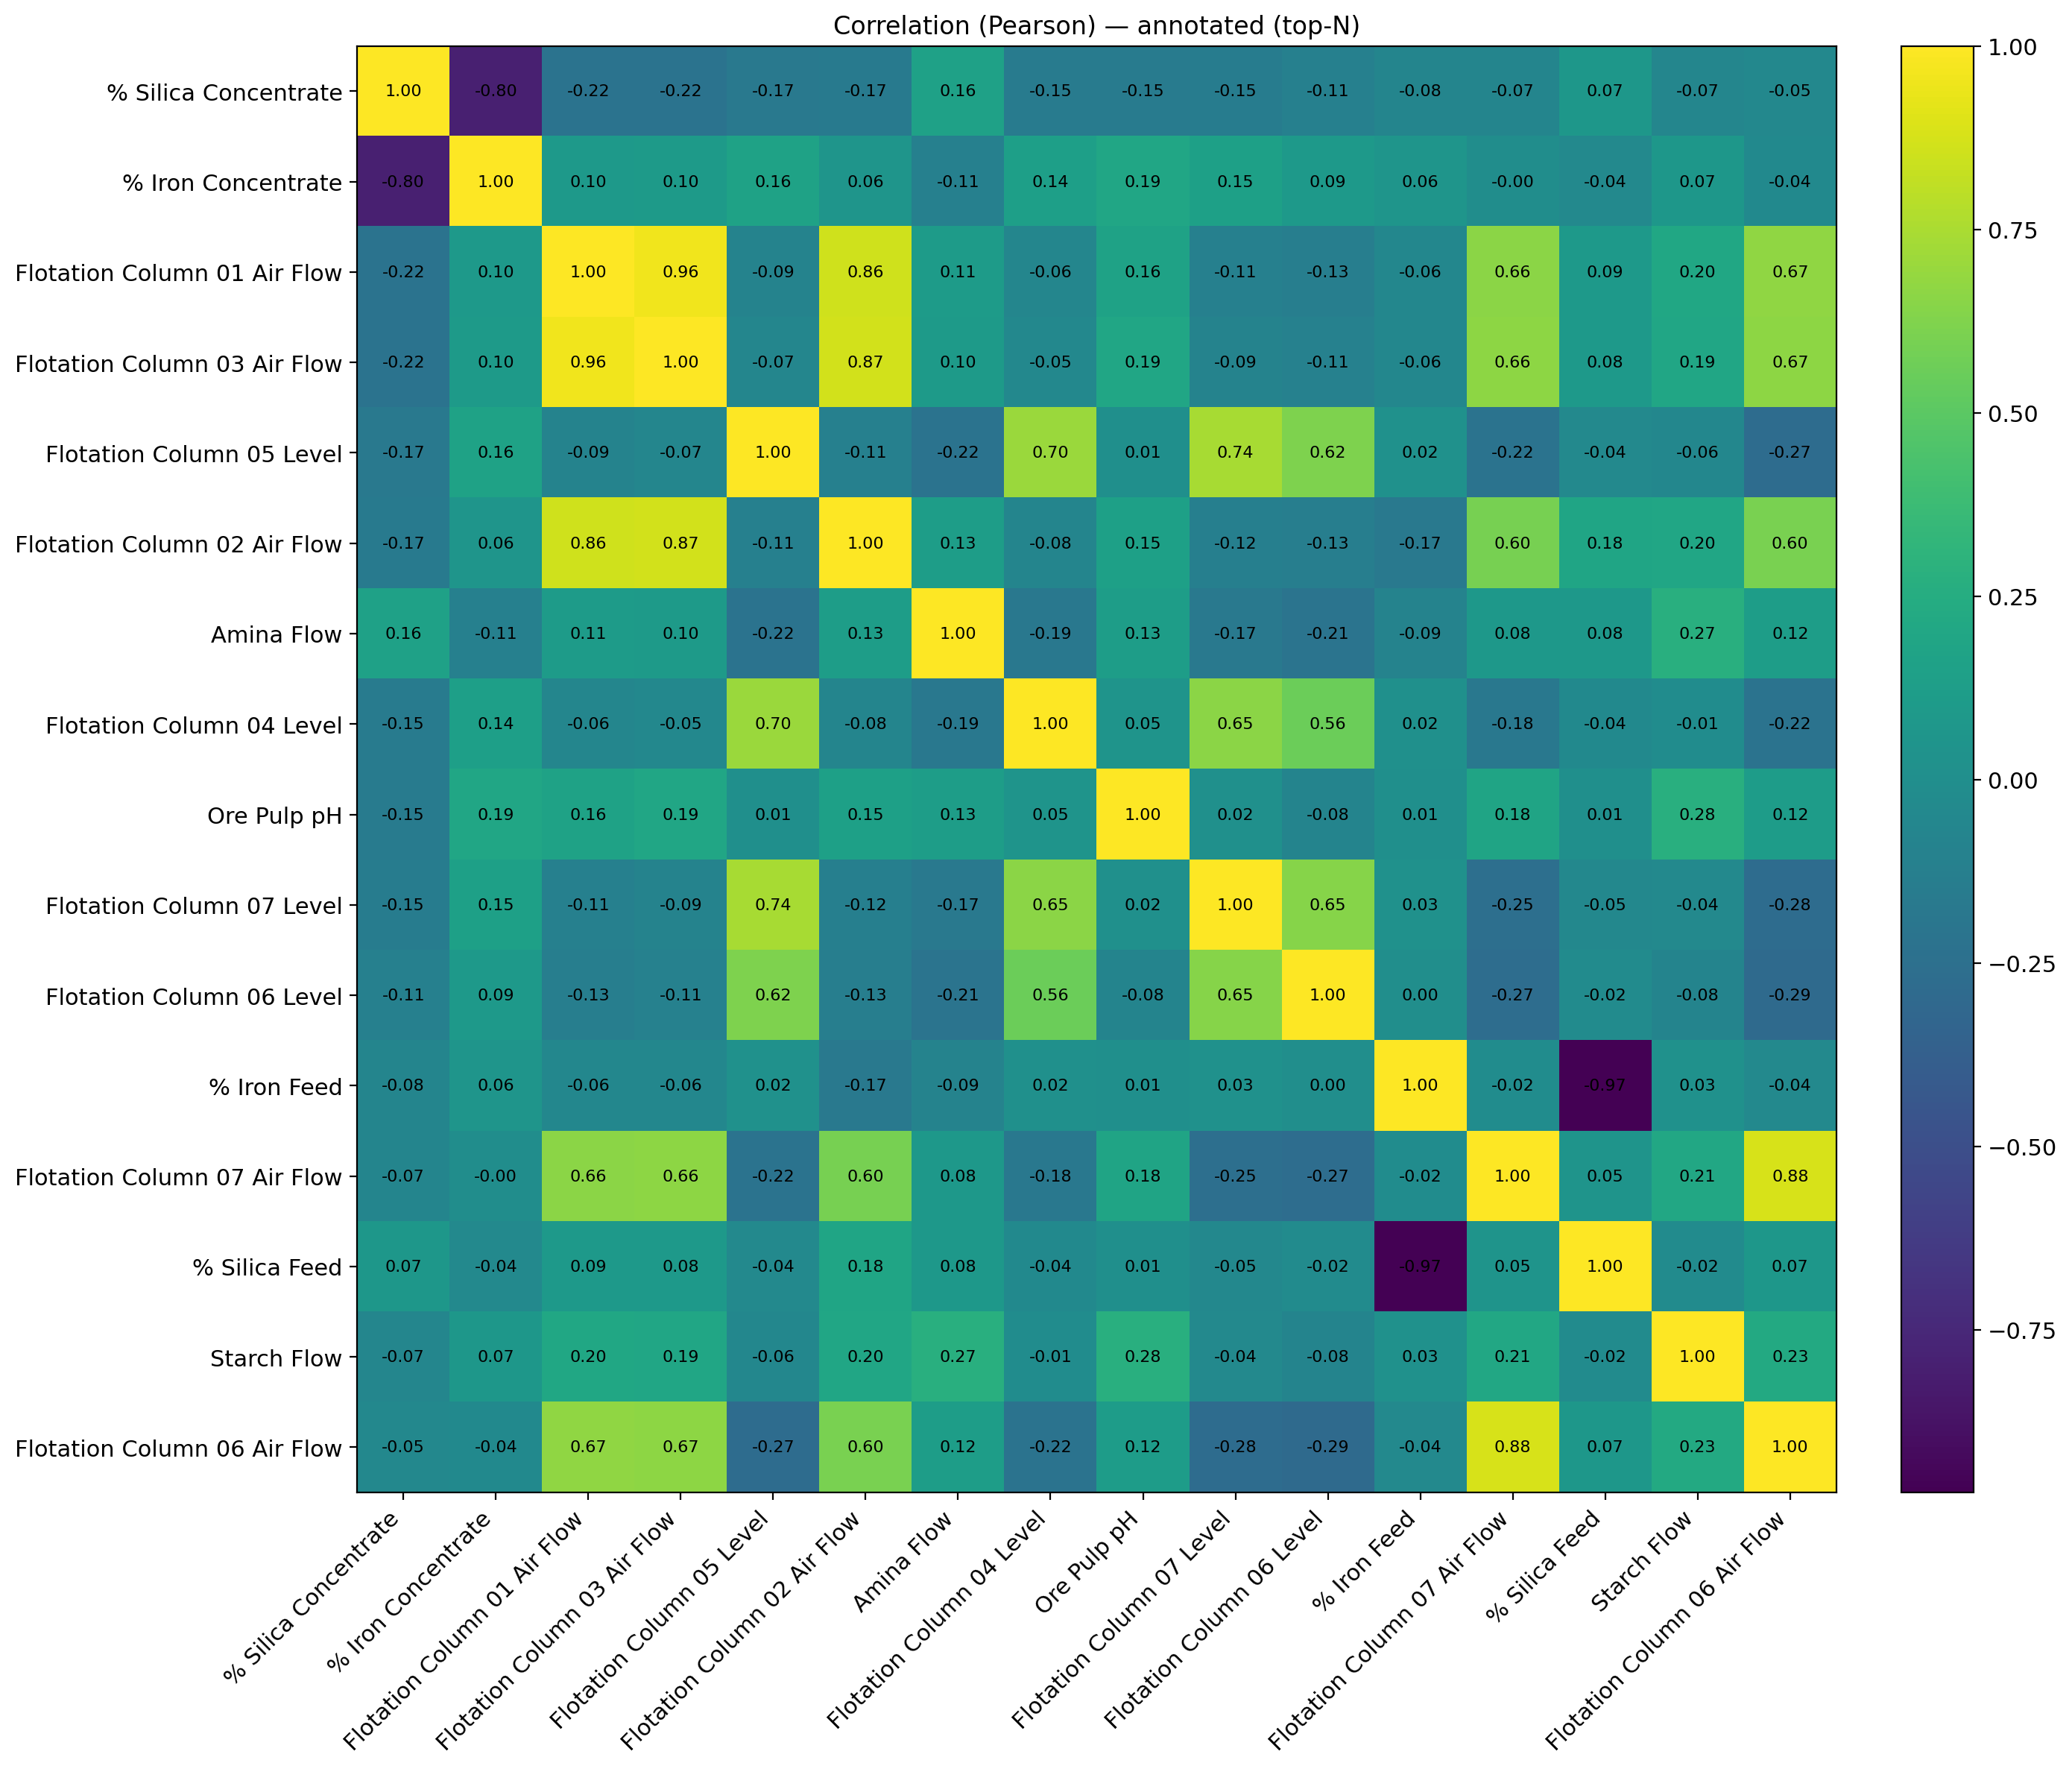

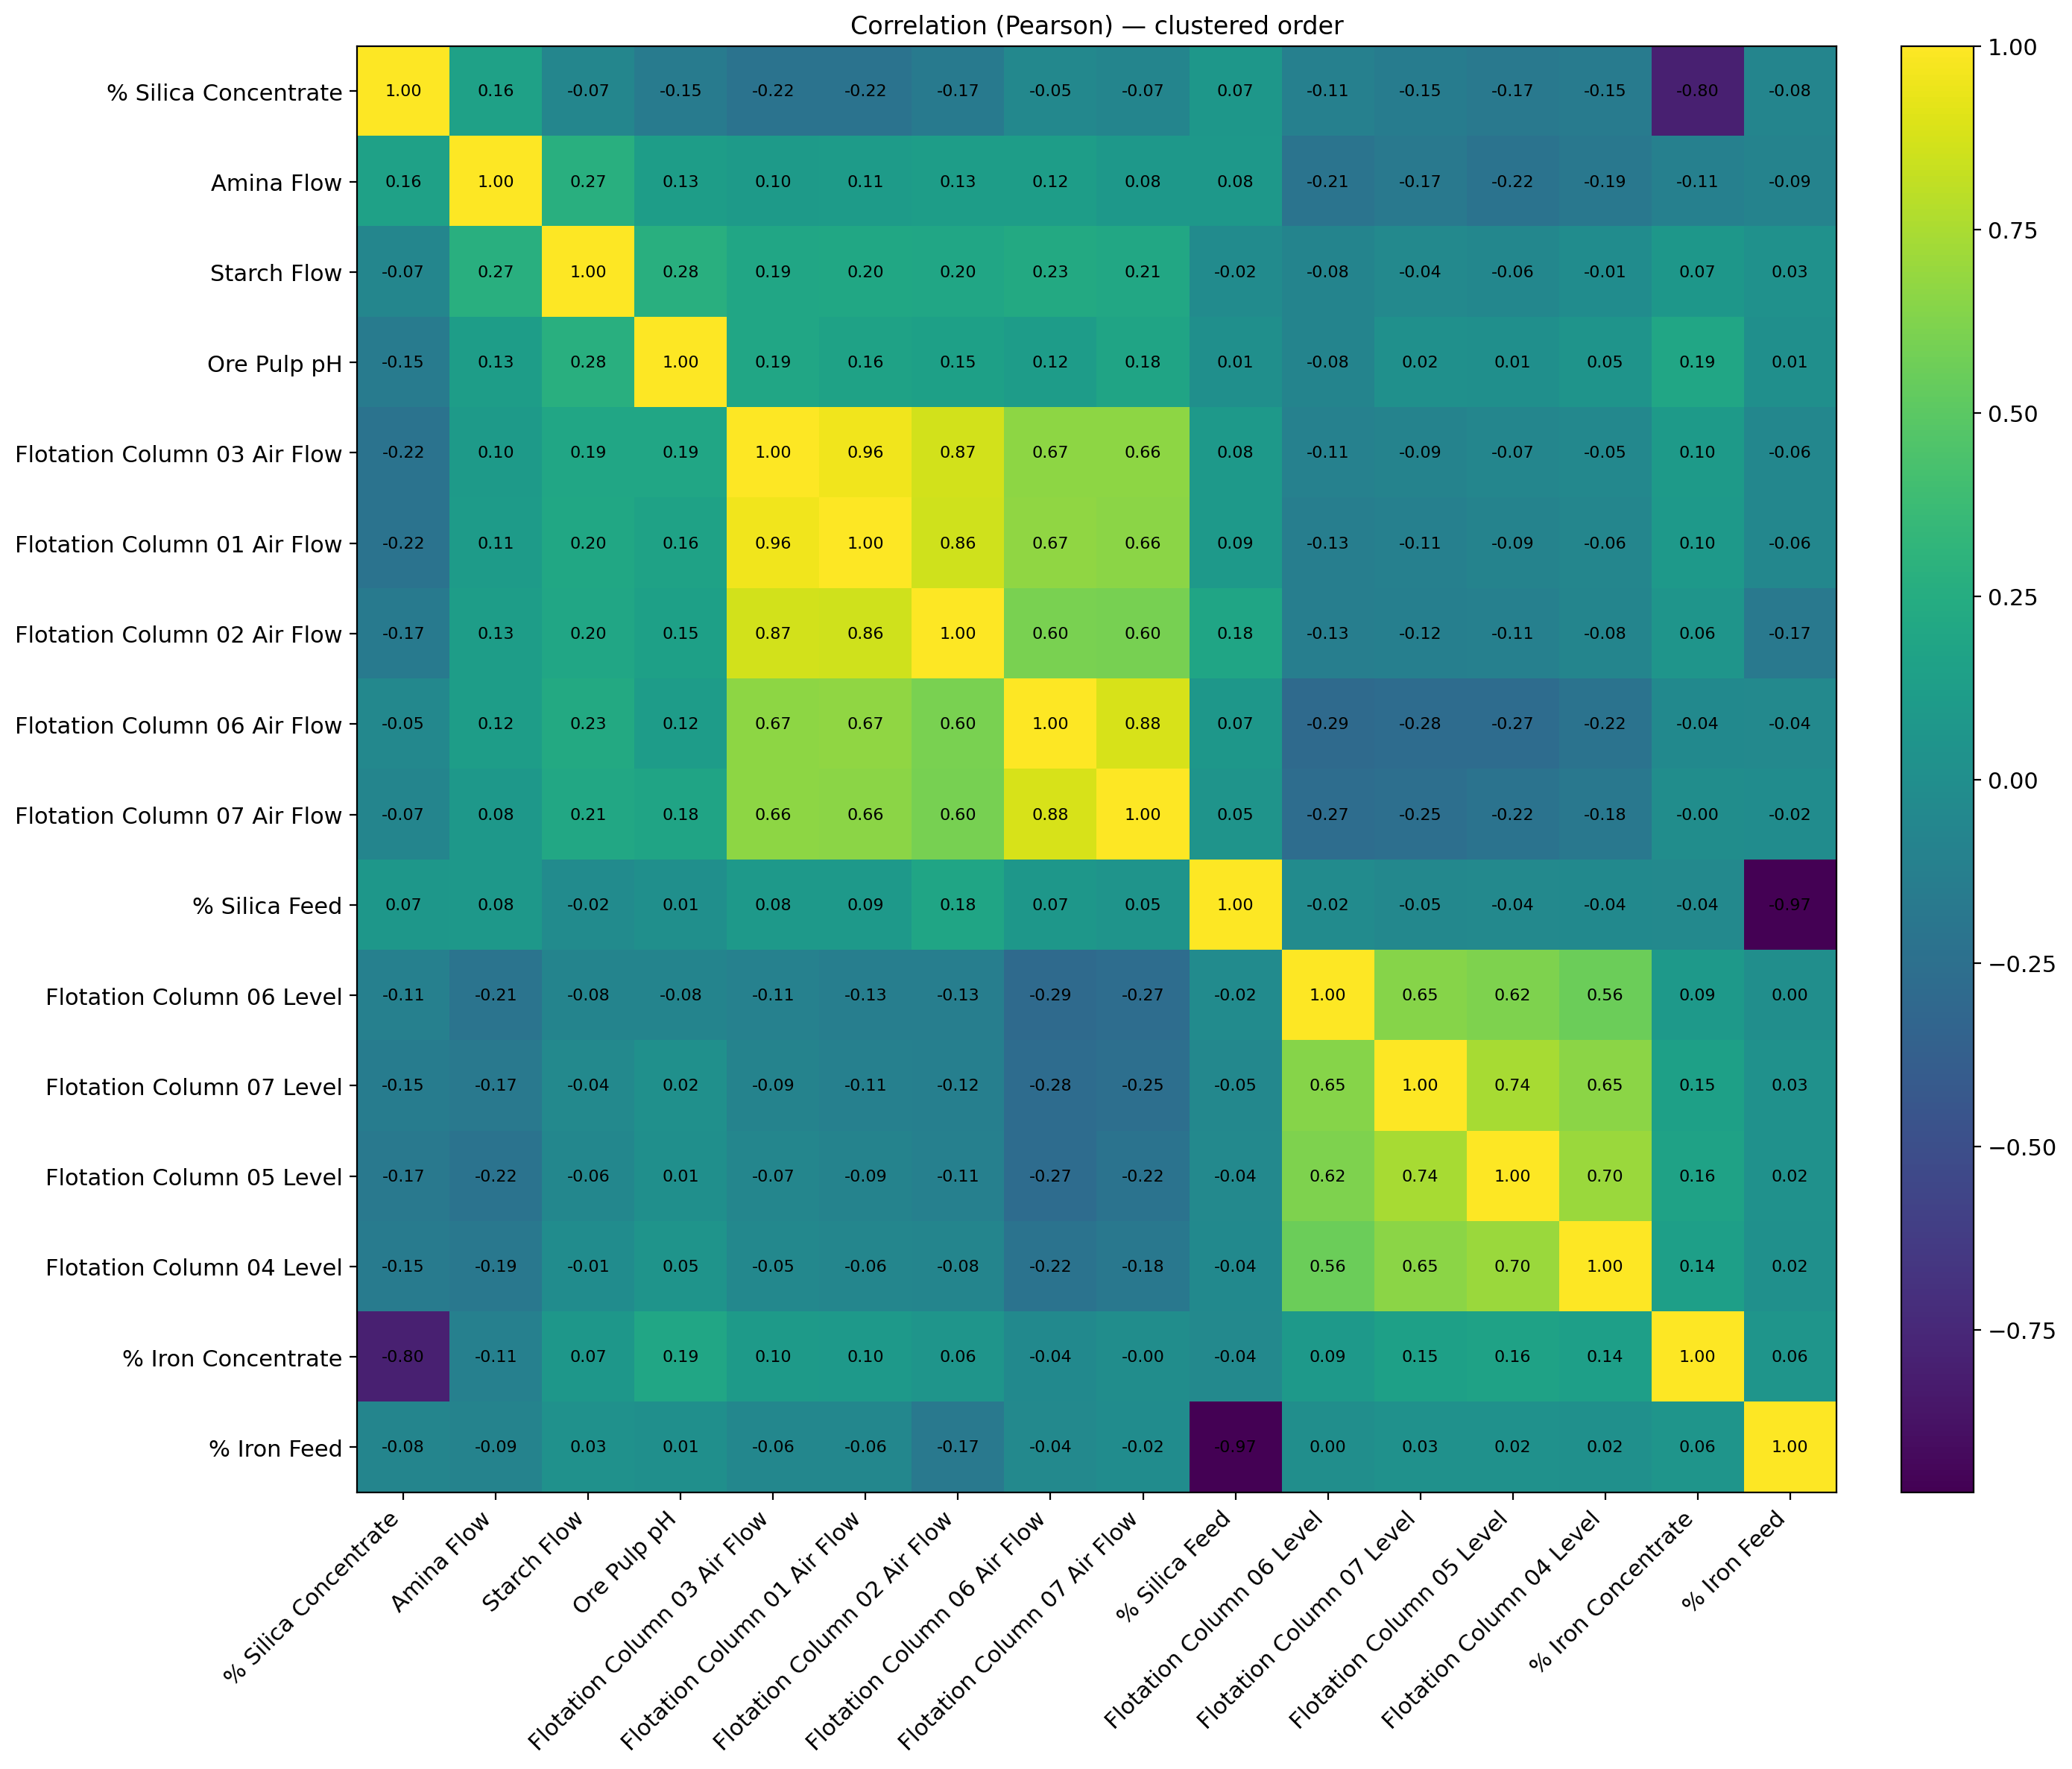

In [ ]:

# Curate to top-N for readability; annotate numbers; add lightweight clustering for order
cand = [c for c in min1.columns if c != tgt]
pairs = []
for c in cand:
    v = min1[c].corr(min1[tgt])
    if pd.notna(v): pairs.append((c, abs(v)))
pairs.sort(key=lambda x: -x[1])
top = [c for c,_ in pairs[:TOPN_FEATURES]]

corr_sub = min1[[tgt] + top].corr(method="pearson")
annotated_corr_heatmap(corr_sub, title="Correlation (Pearson) — annotated (top-N)",
                       out_png="artifacts/correlation_pearson_annot.png", fmt=".2f")
pd.Series(dict(pairs[:10])).to_frame("abs_pearson").to_csv(ART/"top_corr_pearson.csv")

# Simple nearest-neighbor ordering by similarity
corr = min1[[tgt] + top].corr().values
order = [0]
unused = set(range(1, corr.shape[0]))
while unused:
    last = order[-1]
    nxt = max(unused, key=lambda j: corr[last, j])
    order.append(nxt); unused.remove(nxt)
ordered_cols = [min1[[tgt] + top].columns[i] for i in order]
corr_ord = min1[ordered_cols].corr()
annotated_corr_heatmap(corr_ord, title="Correlation (Pearson) — clustered order",
                       out_png="artifacts/correlation_pearson_clustered.png", fmt=".2f")



## 10) Key Relationships (scatters + binned trendlines)


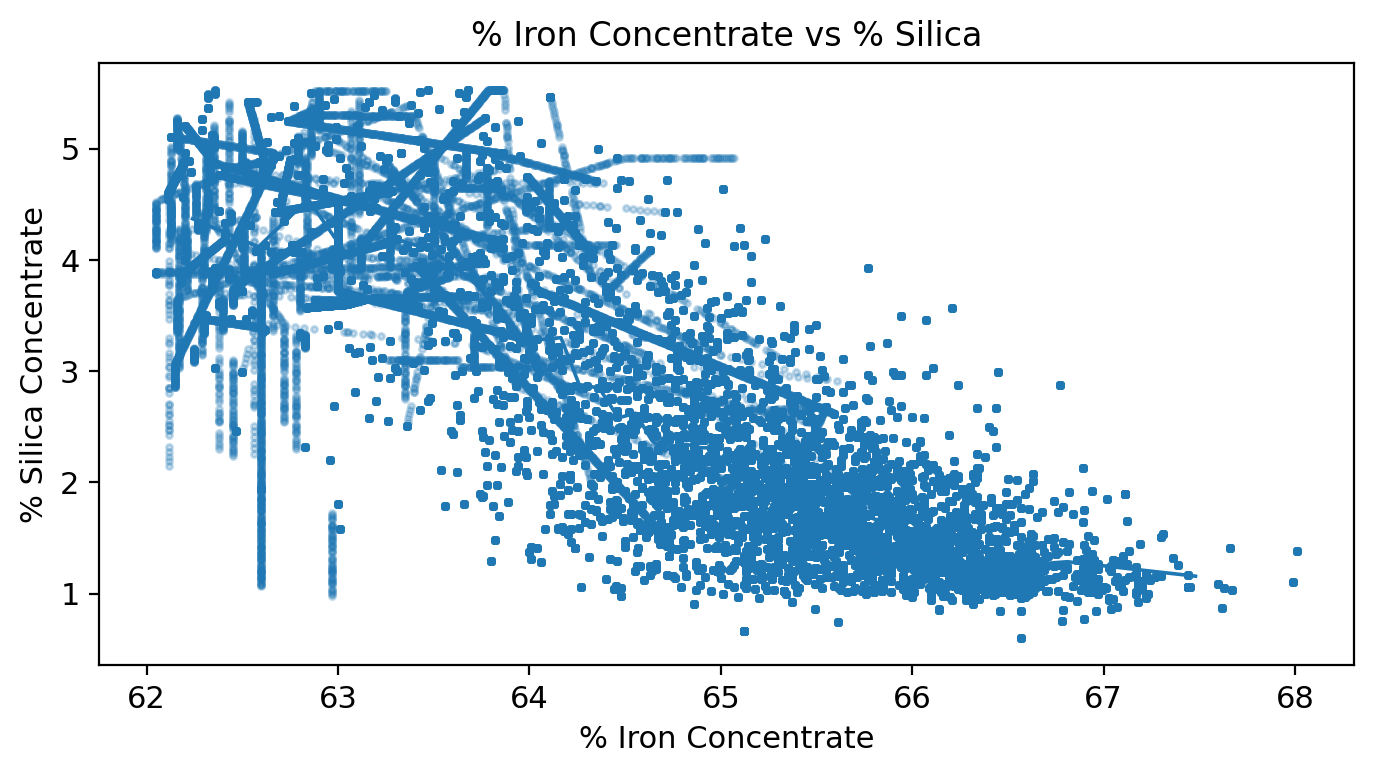

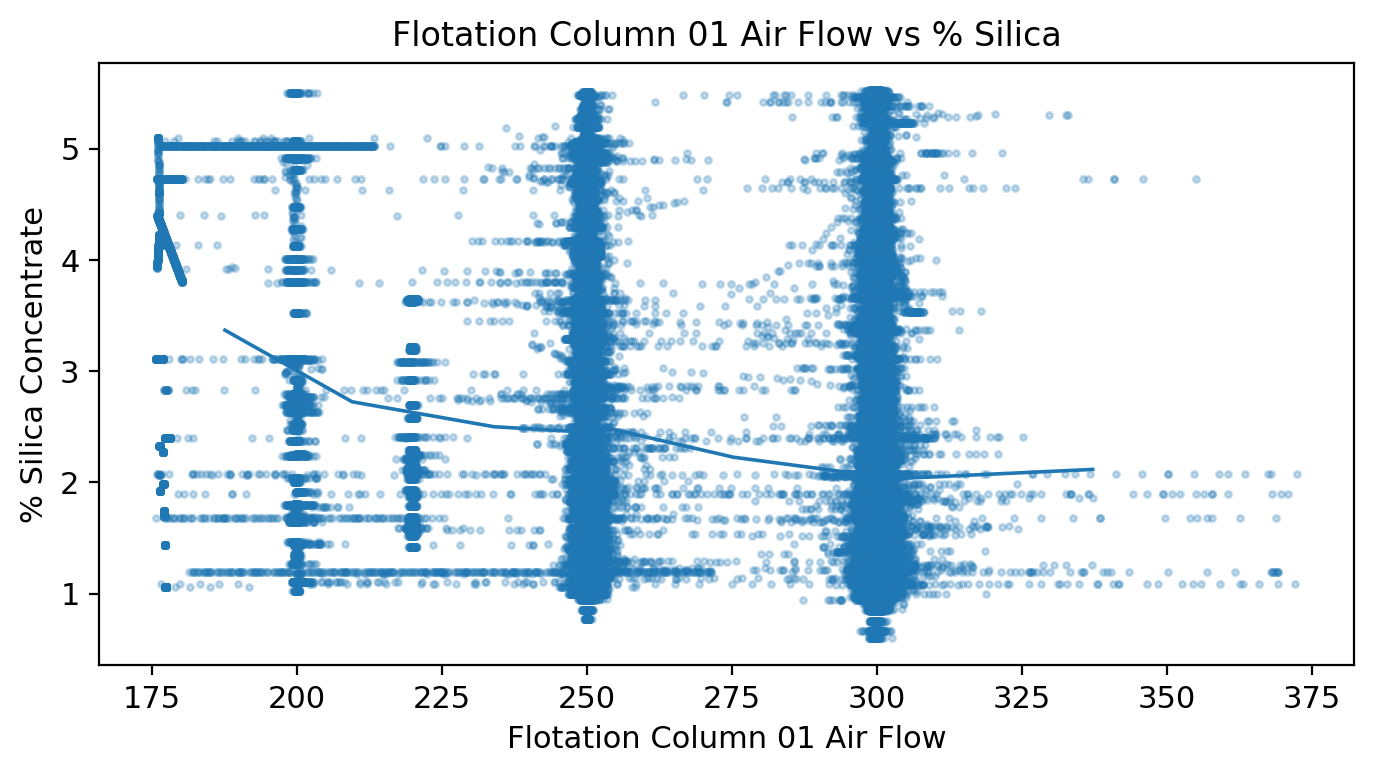

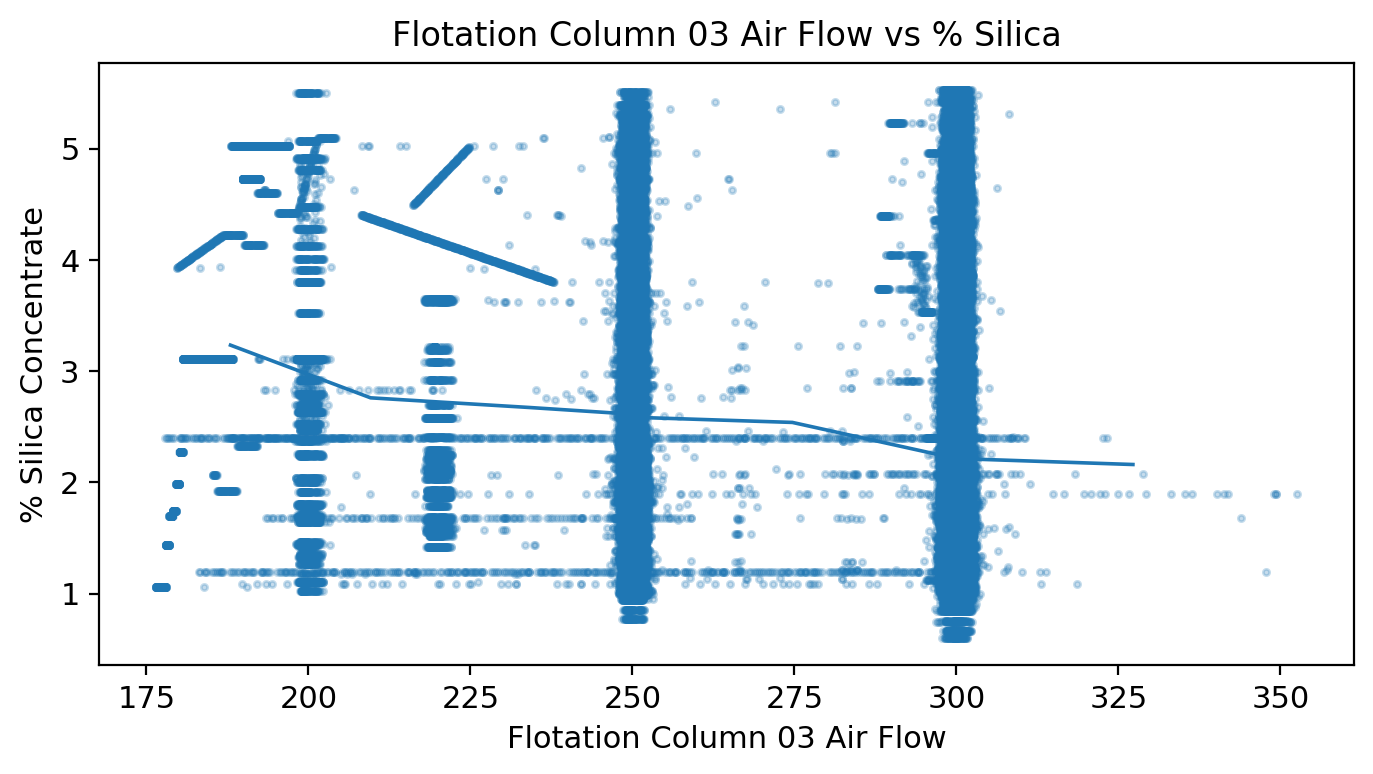

In [ ]:

# Keep the same comparisons but add binned trendlines for clarity
if ("% Iron Concentrate" in min1.columns) and (tgt in min1.columns):
    scatter_with_binned_trend(min1["% Iron Concentrate"], min1[tgt],
                              title="% Iron Concentrate vs % Silica",
                              out_png="artifacts/scatter_iron_vs_silica.png")
else:
    print("Columns not found for Iron vs Silica")

col01 = "Flotation Column 01 Air Flow"
if (col01 in min1.columns) and (tgt in min1.columns):
    scatter_with_binned_trend(min1[col01], min1[tgt],
                              title="Flotation Column 01 Air Flow vs % Silica",
                              out_png="artifacts/scatter_col01_airflow_vs_silica.png")
else:
    print("Columns not found for Column 01 Air Flow vs Silica")

col03 = "Flotation Column 03 Air Flow"
if (col03 in min1.columns) and (tgt in min1.columns):
    scatter_with_binned_trend(min1[col03], min1[tgt],
                              title="Flotation Column 03 Air Flow vs % Silica",
                              out_png="artifacts/scatter_col03_airflow_vs_silica.png")
else:
    print("Columns not found for Column 03 Air Flow vs Silica")



## 11) Lead–Lag Map (−60..+60 min) + best‑lag table


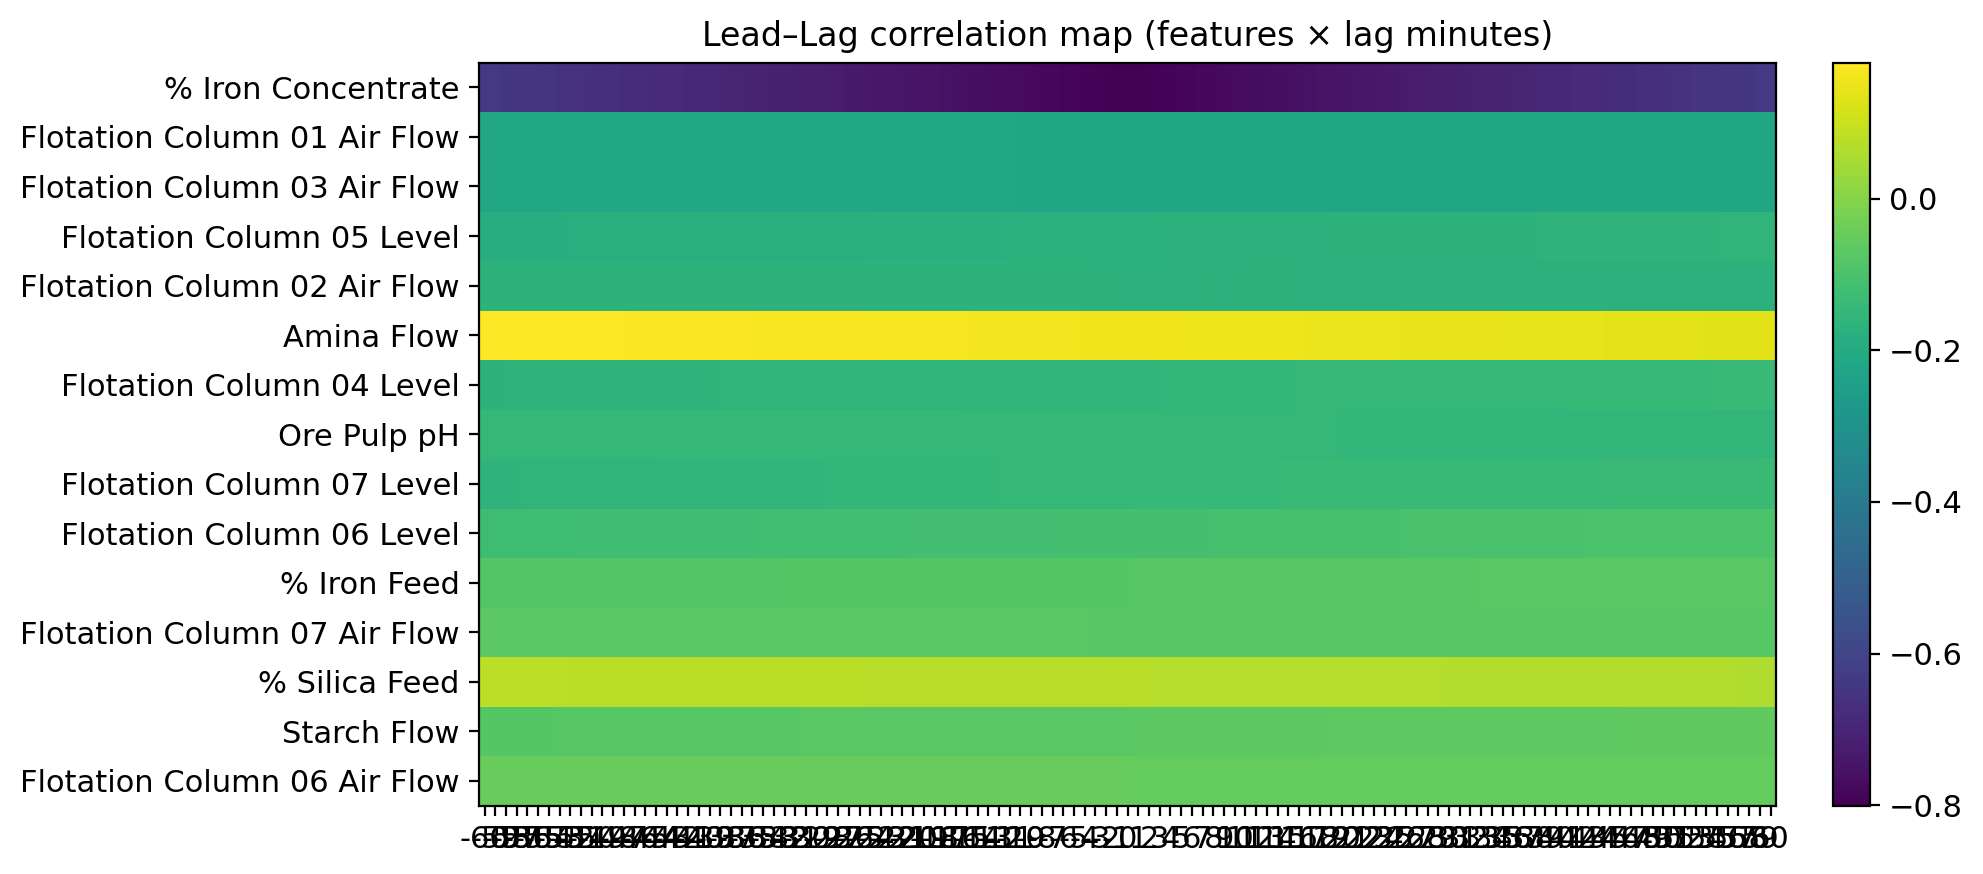

,feature,best_lag_min,corr_at_best
5,Amina Flow,-60,0.179510
12,% Silica Feed,-60,0.081041
14,Flotation Column 06 Air Flow,-60,-0.048612
13,Starch Flow,60,-0.058643
11,Flotation Column 07 Air Flow,-60,-0.069292
10,% Iron Feed,60,-0.069933
9,Flotation Column 06 Level,60,-0.096054
8,Flotation Column 07 Level,60,-0.130614
6,Flotation Column 04 Level,60,-0.140688
7,Ore Pulp pH,0,-0.147906


In [ ]:

# Provide evidence for labeling delay strategy used later in modeling
lags = np.arange(-LEAD_LAG_MAX, LEAD_LAG_MAX+1)
ll_map = np.zeros((len(top), len(lags))) * np.nan
y = min1[tgt]
for i, c in enumerate(top):
    s = min1[c]
    for j, L in enumerate(lags):
        if L >= 0:
            ll_map[i, j] = y.shift(-L).corr(s)
        else:
            ll_map[i, j] = y.corr(s.shift(+L))

fig, ax = plt.subplots(figsize=(10, max(4, 0.3*len(top))))
im = ax.imshow(ll_map, aspect="auto", interpolation="nearest")
ax.set_yticks(range(len(top))); ax.set_yticklabels(top)
ax.set_xticks(range(len(lags))); ax.set_xticklabels(lags)
ax.set_title("Lead–Lag correlation map (features × lag minutes)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout(); fig.savefig(ART/"lead_lag_heatmap.png", bbox_inches="tight")
plt.show()

best_idx = np.nanargmax(ll_map, axis=1)
best_lag = [int(lags[j]) for j in best_idx]
best_val = [float(ll_map[i, best_idx[i]]) for i in range(len(top))]
lag_summary = pd.DataFrame({"feature": top, "best_lag_min": best_lag, "corr_at_best": best_val}).sort_values("corr_at_best", ascending=False)
lag_summary.to_csv(ART/"lead_lag_summary.csv", index=False)
lag_summary.head(10)



## 12) Non‑linear Dependency (Mutual Information)


In [ ]:

# Adds MI to capture non-linear relations missed by correlation; optional if sklearn missing
try:
    from sklearn.feature_selection import mutual_info_regression
    X = min1.drop(columns=[tgt]).fillna(method="ffill").fillna(method="bfill")
    ymi = min1[tgt].fillna(method="ffill").fillna(method="bfill")
    valid = ymi.notna()
    mi = mutual_info_regression(X.loc[valid].values, ymi.loc[valid].values, discrete_features=False, random_state=0)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    mi_series.to_csv(ART/"mutual_information.csv")
    mi_series.head(10)
except Exception as e:
    print("Mutual information skipped (install scikit-learn). Error:", e)



## 13) Drift Pre‑Check (PSI: early vs late)


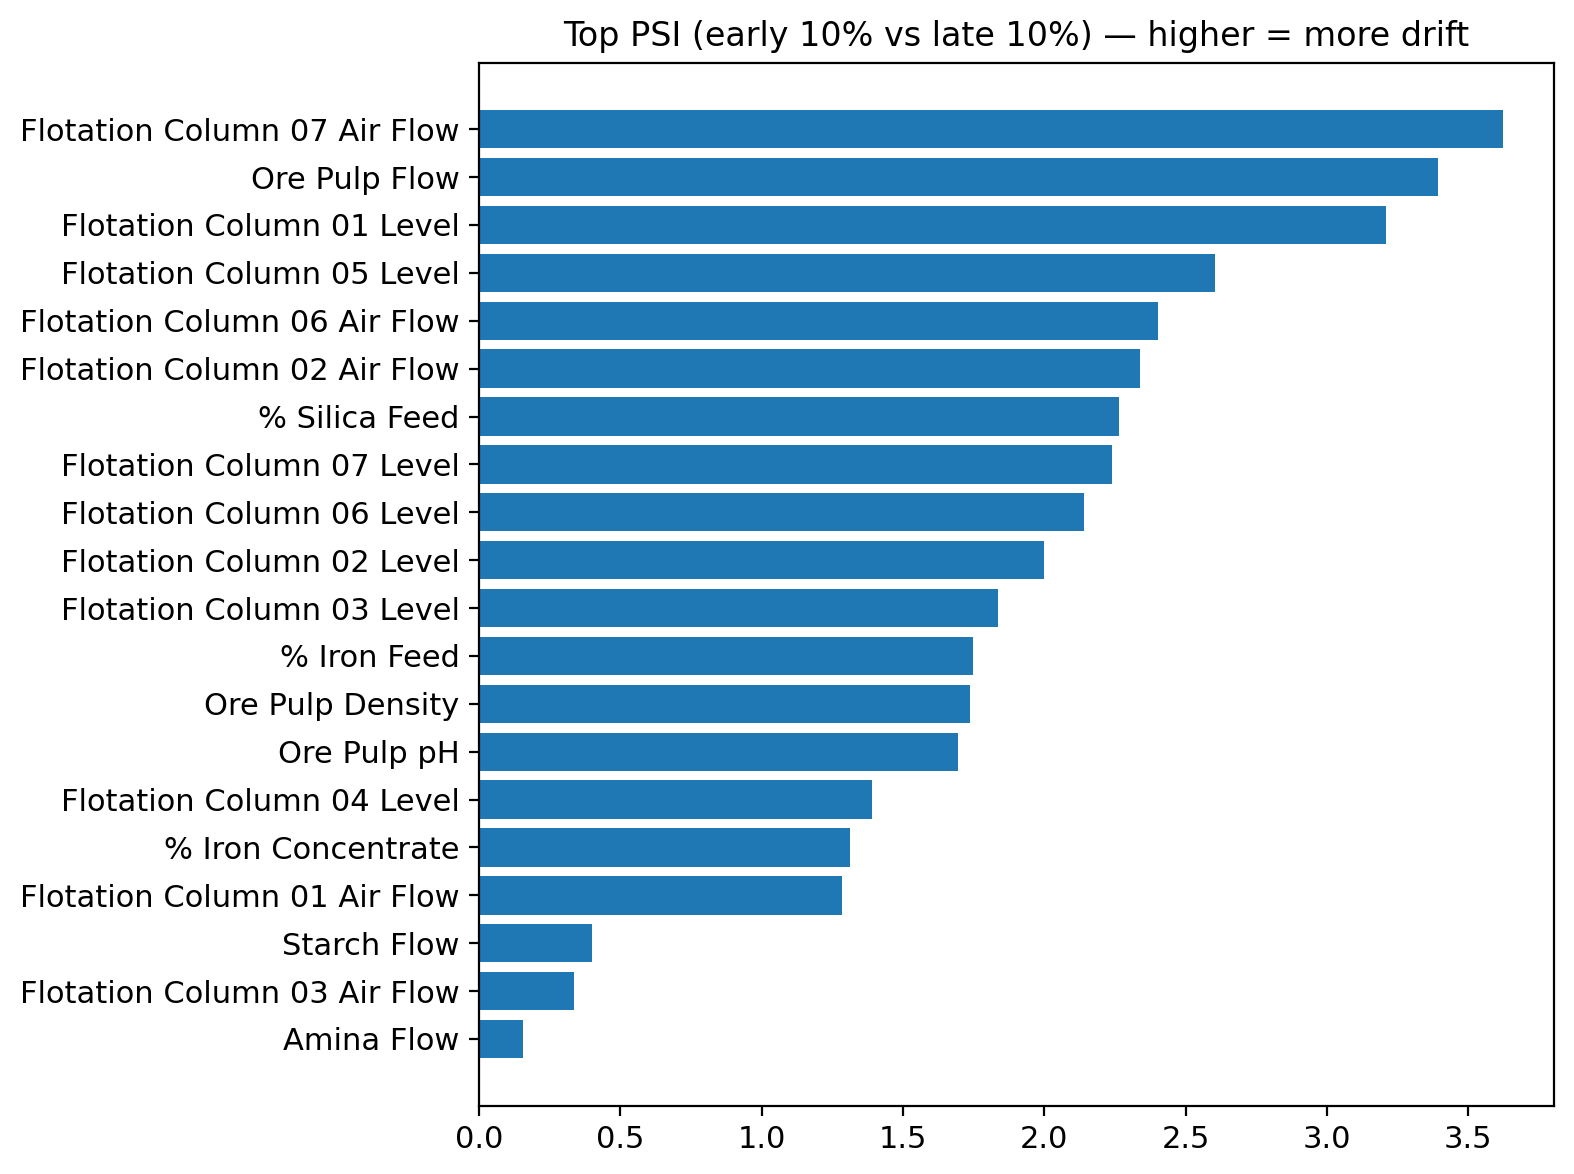

In [ ]:

# A first look at distribution shift risk (feeds slide on Responsible AI / Monitoring)
def psi_numeric(ref: np.ndarray, cur: np.ndarray, bins=10):
    ref = ref[~np.isnan(ref)]; cur = cur[~np.isnan(cur)]
    if len(ref) < 100 or len(cur) < 100:
        return np.nan
    qs = np.linspace(0, 1, bins+1)
    quantiles = np.quantile(ref, qs); quantiles = np.unique(quantiles)
    if len(quantiles) < 3:
        return np.nan
    ref_hist, _ = np.histogram(ref, bins=quantiles)
    cur_hist, _ = np.histogram(cur, bins=quantiles)
    ref_p = ref_hist / ref_hist.sum() if ref_hist.sum() > 0 else np.full_like(ref_hist, 1/len(ref_hist))
    cur_p = cur_hist / cur_hist.sum() if cur_hist.sum() > 0 else np.full_like(cur_hist, 1/len(cur_hist))
    eps = 1e-6
    ref_p = np.maximum(ref_p, eps); cur_p = np.maximum(cur_p, eps)
    return float(np.sum((cur_p - ref_p) * np.log(cur_p / ref_p)))

n = len(min1)
ref = min1.iloc[: max(1, int(0.10*n))]
cur = min1.iloc[-max(1, int(0.10*n)) : ]

psi_vals = {}
for c in min1.columns:
    if c == tgt: 
        continue
    s_ref = ref[c].values.astype(float)
    s_cur = cur[c].values.astype(float)
    psi_vals[c] = psi_numeric(s_ref, s_cur, bins=10)

psi_series = pd.Series(psi_vals).sort_values(ascending=False)
psi_series.to_csv(ART/"psi_early_vs_late.csv")
topN = psi_series.dropna().head(20)
fig, ax = plt.subplots(figsize=(8, max(4, 0.3*len(topN))))
ax.barh(topN.index[::-1], topN.values[::-1])
ax.set_title("Top PSI (early 10% vs late 10%) — higher = more drift")
fig.tight_layout(); fig.savefig(ART/"psi_top.png", bbox_inches="tight")
plt.show()



## 14) Calendar Effects (hour / day‑of‑week)


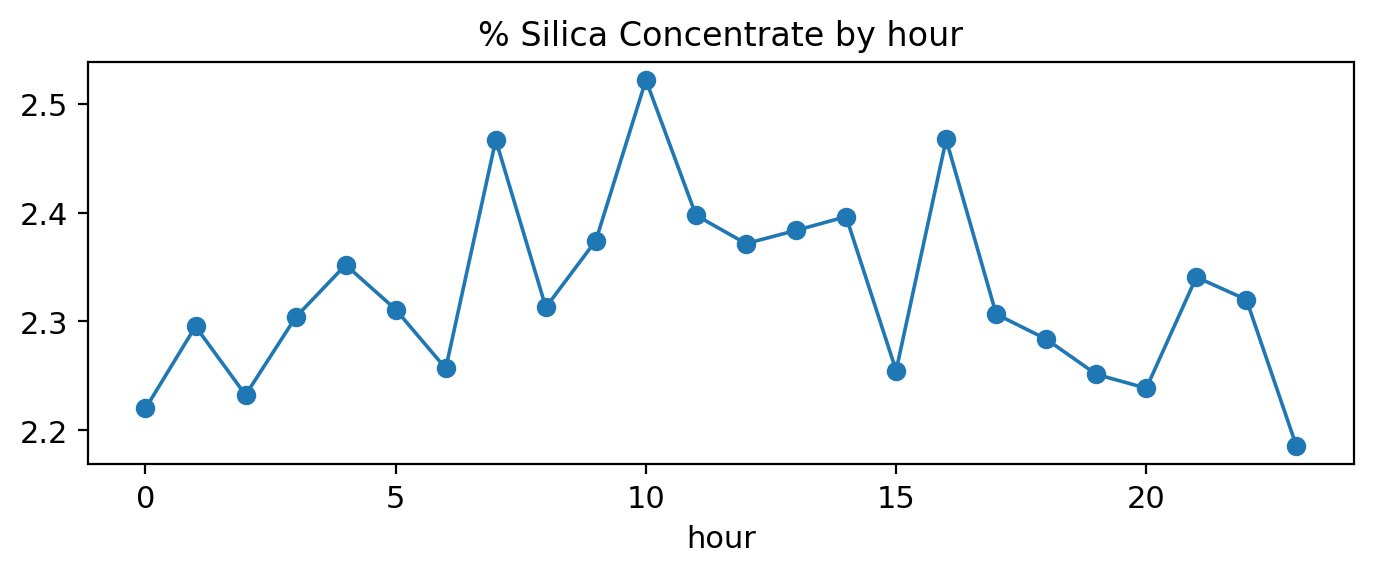

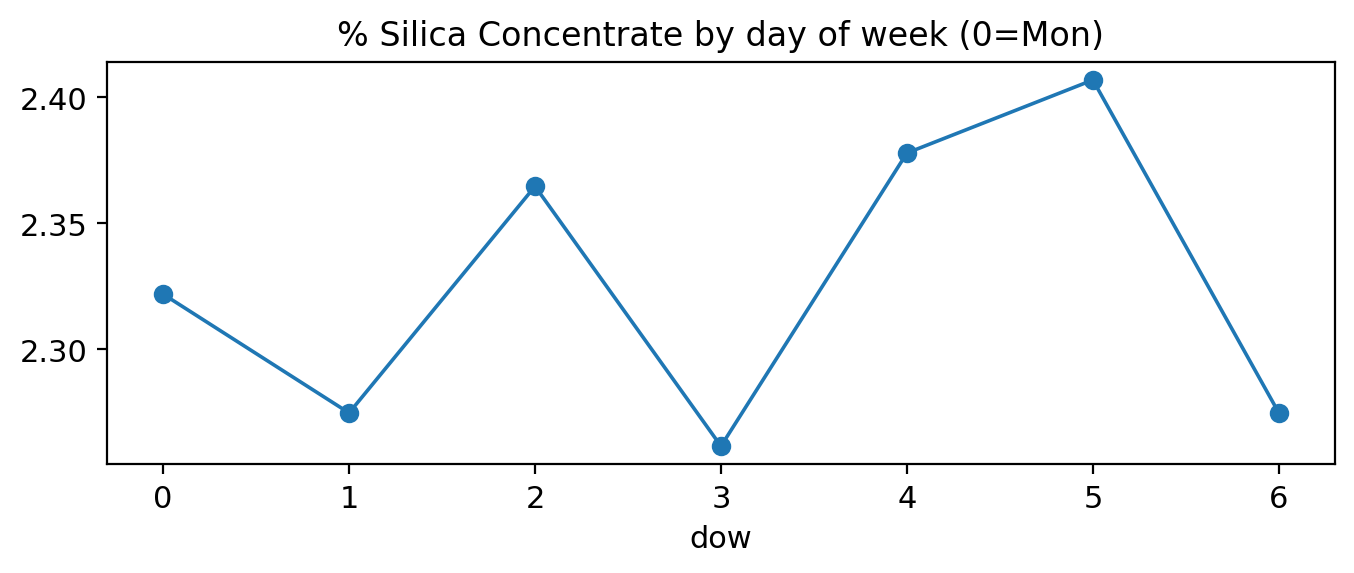

In [ ]:

# Minor seasonality checks for completeness
df_cal = min1.copy()
df_cal["hour"] = df_cal.index.hour
df_cal["dow"]  = df_cal.index.dayofweek

hour_mean = df_cal.groupby("hour")[tgt].mean()
dow_mean  = df_cal.groupby("dow")[tgt].mean()

fig, ax = plt.subplots(figsize=(7,3))
hour_mean.plot(ax=ax, marker="o")
ax.set_title(f"{tgt} by hour")
fig.tight_layout(); fig.savefig(ART/"tgt_by_hour.png", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(7,3))
dow_mean.plot(ax=ax, marker="o")
ax.set_title(f"{tgt} by day of week (0=Mon)")
fig.tight_layout(); fig.savefig(ART/"tgt_by_dow.png", bbox_inches="tight")
plt.show()



## 15) Technical Approach (slides‑ready)
- **Resampling**: use this notebook’s minute‑level means (`min1`).  
- **Labeling**: align lab proxy via **lag_shift** guided by the lead–lag scan; confirm in time‑aware CV.  
- **Features (leak‑safe)**: for key sensors, compute **lags** {1,2,3,5,10,15,30,60}, **rolling stats** {5,15,60} with `.shift(1)`, **differences**, **rate‑of‑change**, and **calendar** features.  
- **Validation**: **blocked time‑series CV** with **embargo** gap.  
- **Prediction Intervals**: quantile regressors + **conformal** calibration (target **80%/95%** coverage).  
- **Monitoring**: PSI/KS feature drift + residual control charts after model fit.



## 16) ROI worked example (course scenario)


In [ ]:

# Adds a sensitivity table and chart directly for slides
throughput = 1000
offspec_hours = 6.0
cost_per_hour = [4000, 6000, 8000]
reduction_pct = [10, 25, 40]

rows=[]
for cph in cost_per_hour:
    for r in reduction_pct:
        daily  = offspec_hours * cph * (r/100.0)
        annual = daily * 365
        rows.append({"cost_per_hour": cph, "reduction_%": r, "daily_$": daily, "annual_$": annual})
roi_tbl = pd.DataFrame(rows)
roi_tbl.to_csv("artifacts/roi_sensitivity.csv", index=False)
roi_tbl.head()


,cost_per_hour,reduction_%,daily_$,annual_$
0,4000,10,2400.0,876000.0
1,4000,25,6000.0,2190000.0
2,4000,40,9600.0,3504000.0
3,6000,10,3600.0,1314000.0
4,6000,25,9000.0,3285000.0


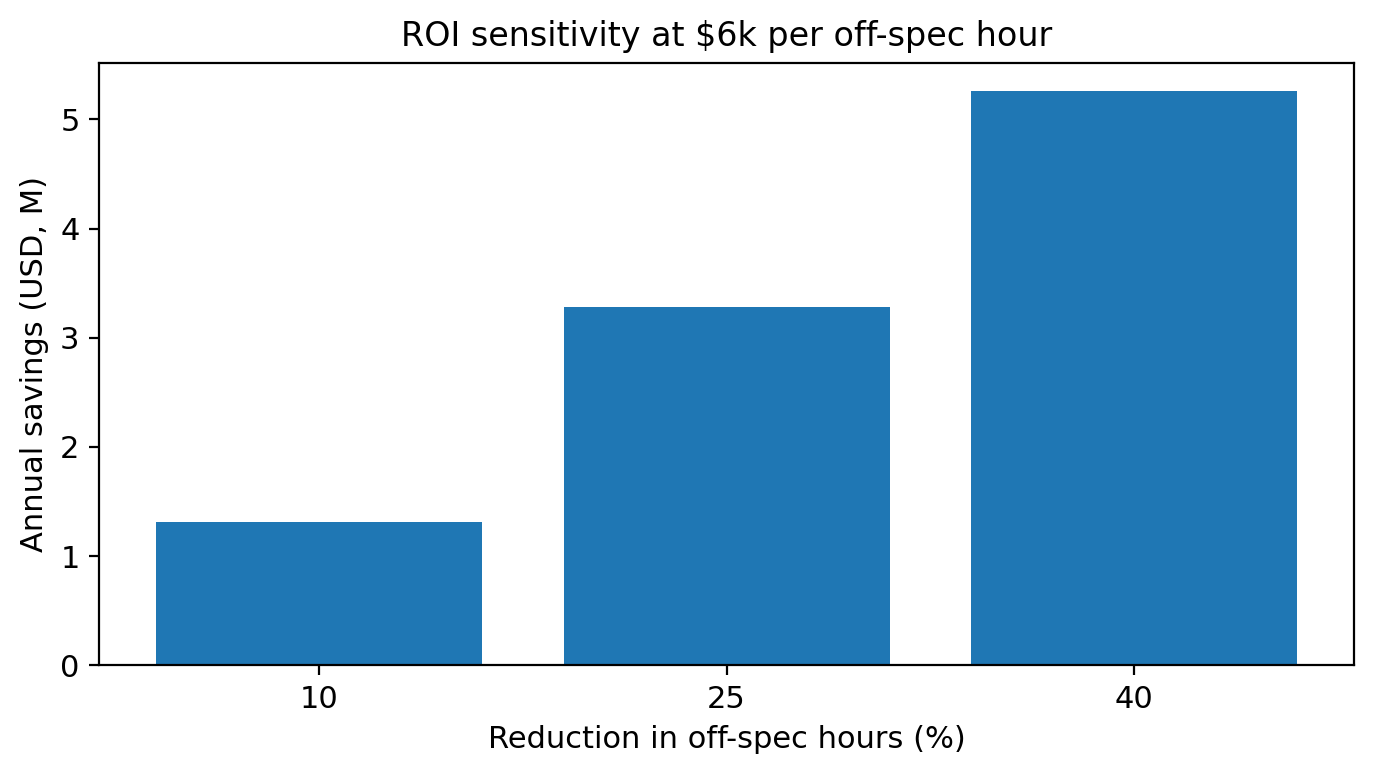

In [ ]:

sub = roi_tbl[roi_tbl["cost_per_hour"]==6000].sort_values("reduction_%")
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(sub["reduction_%"].astype(str), sub["annual_$"]/1e6)
ax.set_ylabel("Annual savings (USD, M)"); ax.set_xlabel("Reduction in off-spec hours (%)")
ax.set_title("ROI sensitivity at $6k per off-spec hour")
fig.tight_layout(); fig.savefig("artifacts/roi_sensitivity.png", bbox_inches="tight")
plt.show()



## 17) Exports, manifest, and slide asset pack


In [ ]:

# Robust save with Parquet→CSV fallback; emit a manifest + zip so slides are easy to assemble
out_parquet = DATA / "mining_1min.parquet"
out_csv     = DATA / "mining_1min.csv"

def save_minute_dataset(df: pd.DataFrame):
    try:
        import pyarrow  # noqa: F401
        df.to_parquet(out_parquet, index=True)
        print("Saved:", out_parquet)
    except Exception as e:
        print("Parquet not available:", e)
        print("Saving CSV instead. To enable Parquet next time, install pyarrow:")
        print("  pip install pyarrow")
        df.to_csv(out_csv, index=True)
        print("Saved:", out_csv)

save_minute_dataset(min1)

# Export manifest
from pathlib import Path as _P
import json, pprint, zipfile

minute_path = (DATA / "mining_1min.parquet")
if not minute_path.exists():
    minute_path = (DATA / "mining_1min.csv")
man = {
    "minute_dataset": str(minute_path.resolve()),
    "figures": sorted([str(p) for p in _P("artifacts").glob("*.png")]),
    "tables":  sorted([str(p) for p in _P("artifacts").glob("*.csv")]),
}
print("Export manifest:"); pprint.pprint(man)
(_P("artifacts") / "export_manifest.json").write_text(json.dumps(man, indent=2))

# Slide asset zip
zip_path = _P("artifacts") / "feasibility_slide_assets.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in _P("artifacts").glob("*.png"):
        zf.write(p, arcname=p.name)
    for p in _P("artifacts").glob("*.csv"):
        zf.write(p, arcname=p.name)
print("Slide asset pack:", zip_path.resolve())
print("Artifacts dir:", ART.resolve())


Parquet not available: No module named 'pyarrow'
Saving CSV instead. To enable Parquet next time, install pyarrow:
  pip install pyarrow
Saved: data/mining_1min.csv
Export manifest:
{'figures': ['artifacts/correlation_pearson_annot.png',
             'artifacts/correlation_pearson_clustered.png',
             'artifacts/daily_coverage.png',
             'artifacts/interval_hist.png',
             'artifacts/lead_lag_heatmap.png',
             'artifacts/missingness_heatmap.png',
             'artifacts/psi_top.png',
             'artifacts/roi_sensitivity.png',
             'artifacts/scatter_col01_airflow_vs_silica.png',
             'artifacts/scatter_col03_airflow_vs_silica.png',
             'artifacts/scatter_iron_vs_silica.png',
             'artifacts/target_acf.png',
             'artifacts/target_distribution.png',
             'artifacts/target_timeseries_head.png',
             'artifacts/target_trailing_1d.png',
             'artifacts/tgt_by_dow.png',
             'artifac